In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from scipy.special import erfinv
from scipy.special import erf
from scipy.stats import skew, kurtosis
from scipy.stats import norm
from scipy.stats import chi2
from matplotlib import rc
from scipy.special import gamma
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.optimize import root_scalar
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import ks_2samp, ksone
import scipy.optimize as opt

In [2]:
m0 = 1.66e-27
K_40_mass = 40*m0 #kg
kb = 1.3806e-23 #J/K
T = 30 #K

beta = 1/(kb*T)

A = np.sqrt(beta/math.pi)


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Task 1: Basic Statistical Properties

### a)


A function is considered a probability densiy function if it satisfies these two condition: 

- Non-negativity, meaning f(Ew) >= 0 for all Ew >=0
- Normalization, where the integral of the PDF over its domain must be equal to 1

/var/folders/0y/496_zl5905jfg059dd524bvm0000gn/T/ipykernel_26917/2849937601.py:10: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-beta * eps) / np.sqrt(eps)


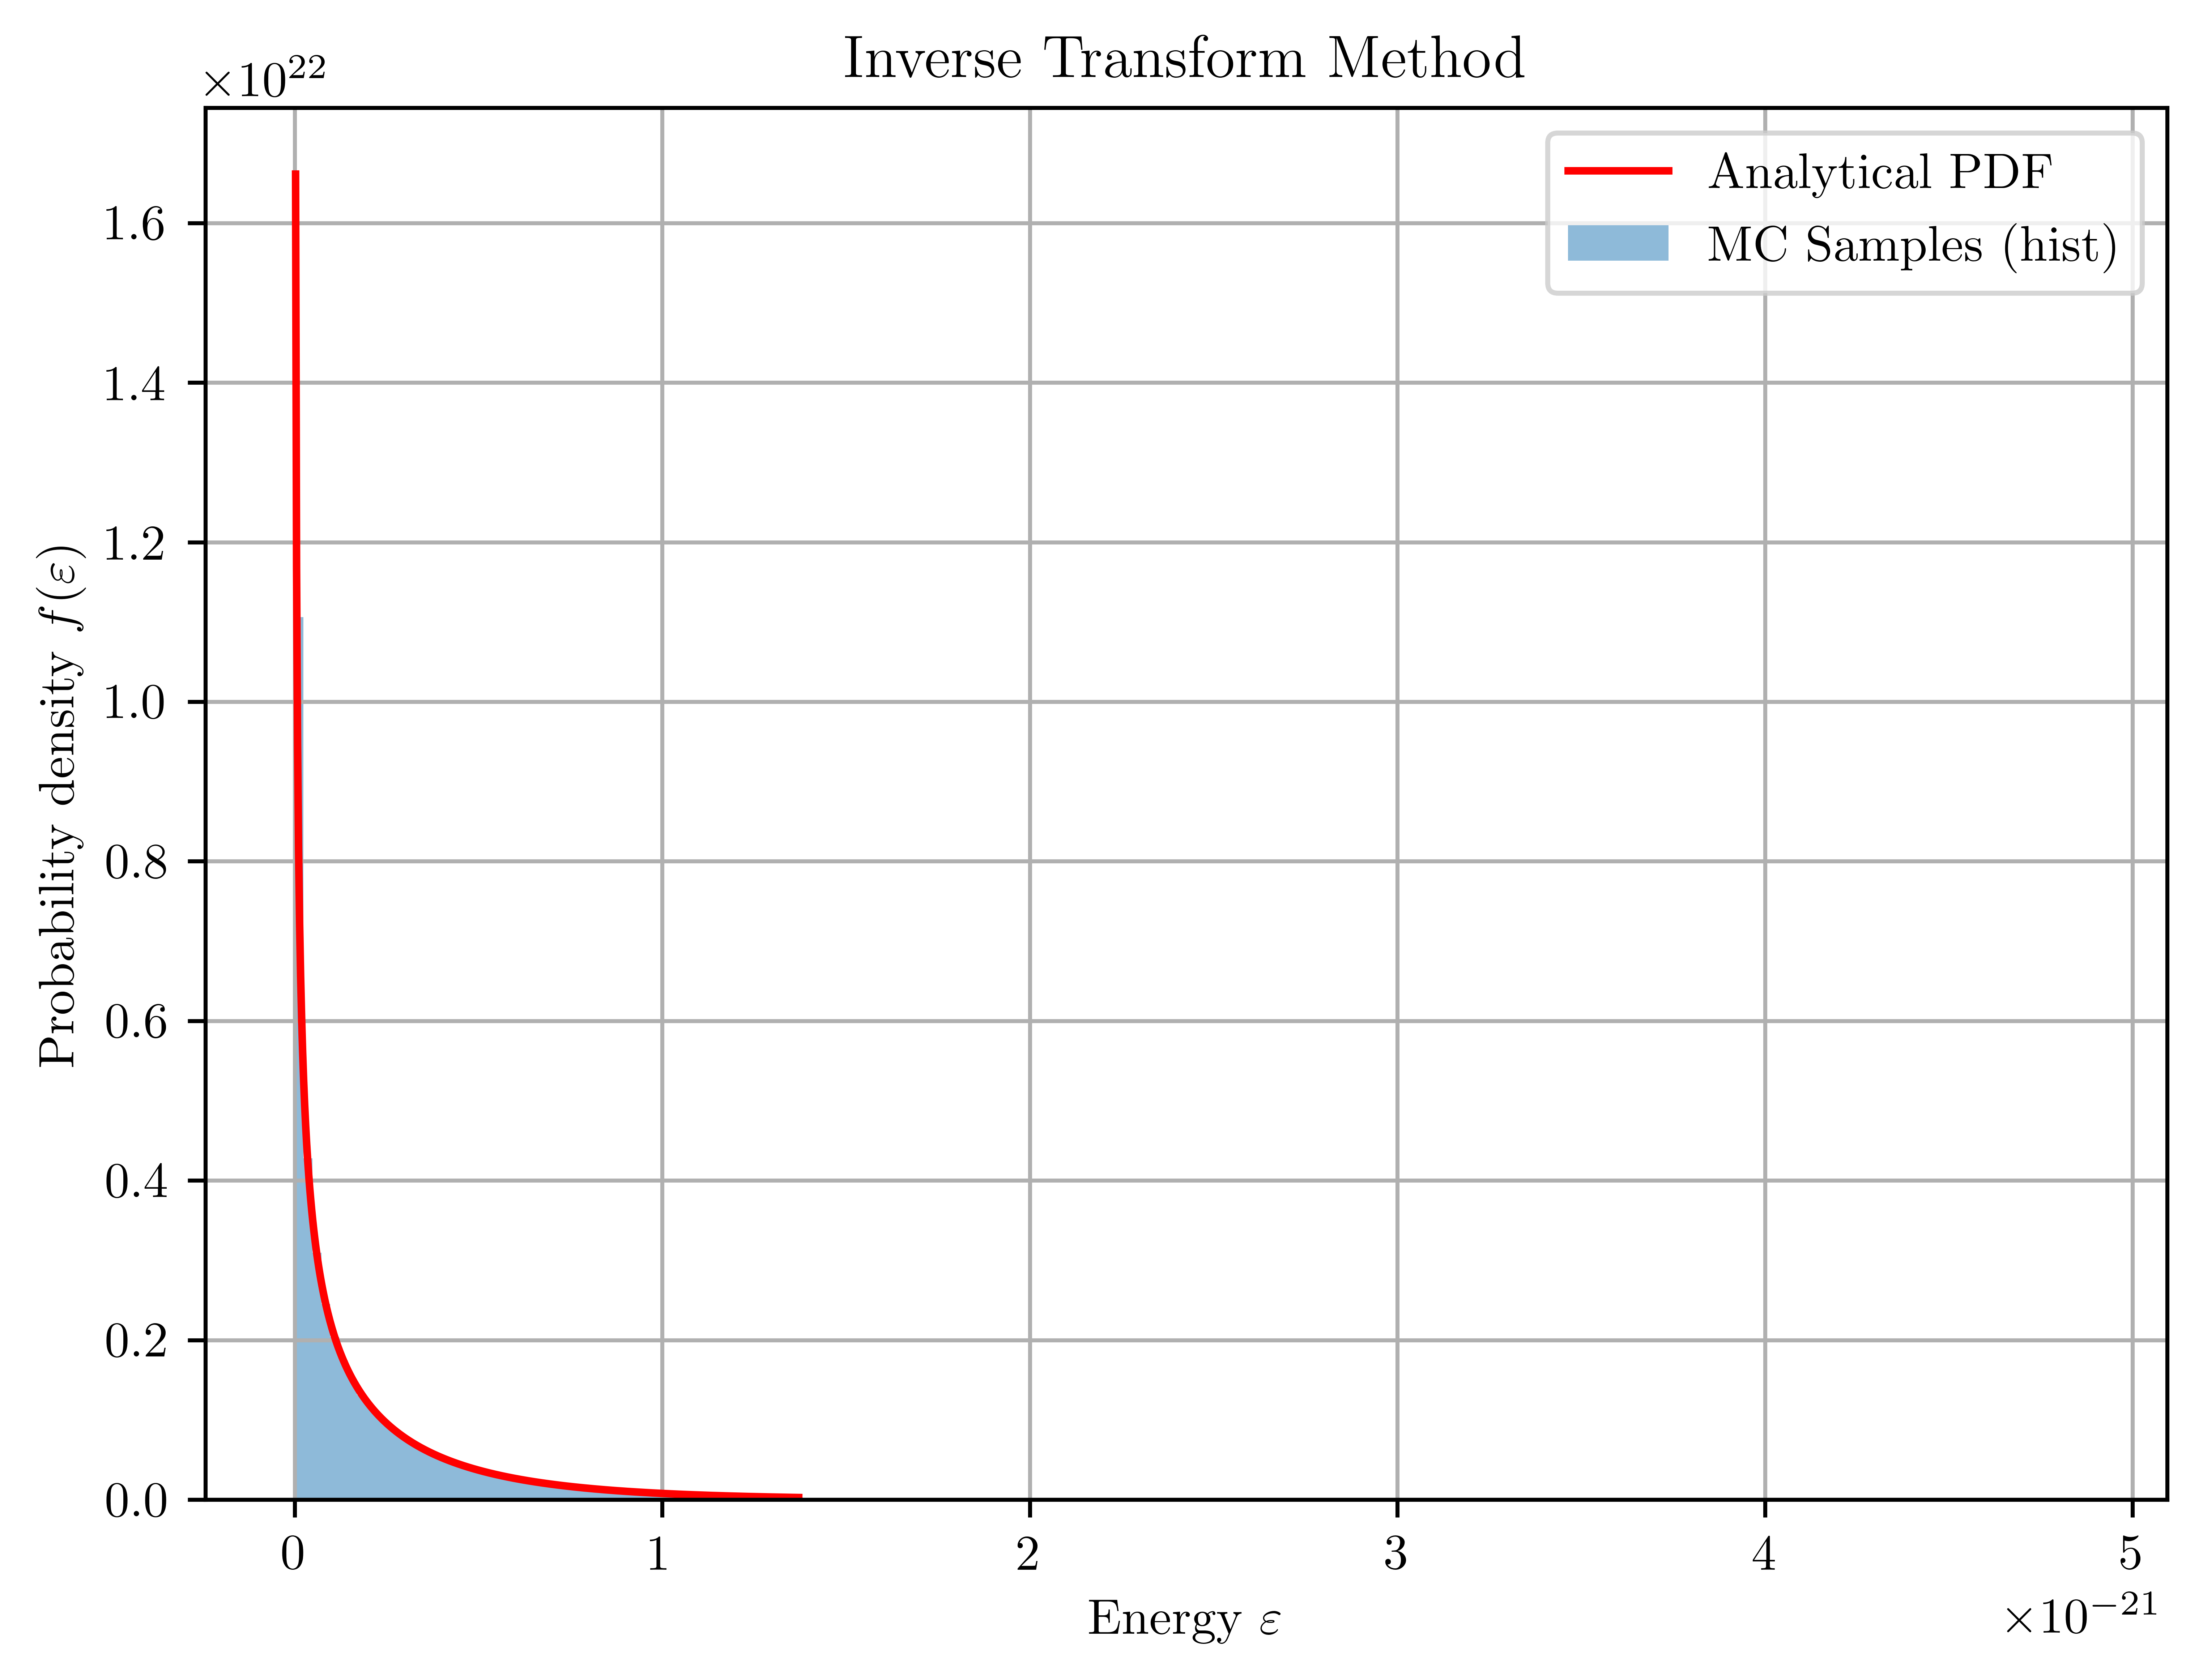

In [3]:


def sample_energy_inverse_transform(N, beta):
    
    U = np.random.rand(N)
    return (erfinv(U)**2) / beta

def pdf(eps, beta):
    
    
    A = np.sqrt(beta / math.pi)
    return A * np.exp(-beta * eps) / np.sqrt(eps)


N = 1000000  


energy_samples = sample_energy_inverse_transform(N, beta)


bins = 200
hist, bin_edges = np.histogram(energy_samples, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


plt.figure(figsize=(7,5), dpi=1000)
plt.bar(bin_centers, hist, width=(bin_edges[1]-bin_edges[0]),
        alpha=0.5, label='MC Samples (hist)')


eps_grid = np.linspace(0, np.percentile(energy_samples, 99.0), 500)
pdf_values = pdf(eps_grid, beta)
plt.plot(eps_grid, pdf_values, 'r-', label='Analytical PDF')

plt.xlabel(r'Energy $\varepsilon$')
plt.ylabel(r'Probability density $f(\varepsilon)$')
plt.title('Inverse Transform Method')

plt.legend()
plt.grid(True)
plt.show()

In [4]:
mean_values = np.mean(sample_energy_inverse_transform(N, beta))

analytical_expectation_value = 0.5 * kb * T


print(f"Sample Mean <Ew>: {mean_values:.5e} J")
print(f"Analytical Expectation Value: {analytical_expectation_value:.5e} J")


print(f"Relative Error: {abs(mean_values - analytical_expectation_value) / analytical_expectation_value:.5e}")

Sample Mean <Ew>: 2.06982e-22 J
Analytical Expectation Value: 2.07090e-22 J
Relative Error: 5.19958e-04


Calculated M: 4.4917998085341875
Sampling Efficiency: 21.12%


/var/folders/0y/496_zl5905jfg059dd524bvm0000gn/T/ipykernel_26917/2958858612.py:4: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-beta * eps) / np.sqrt(eps)


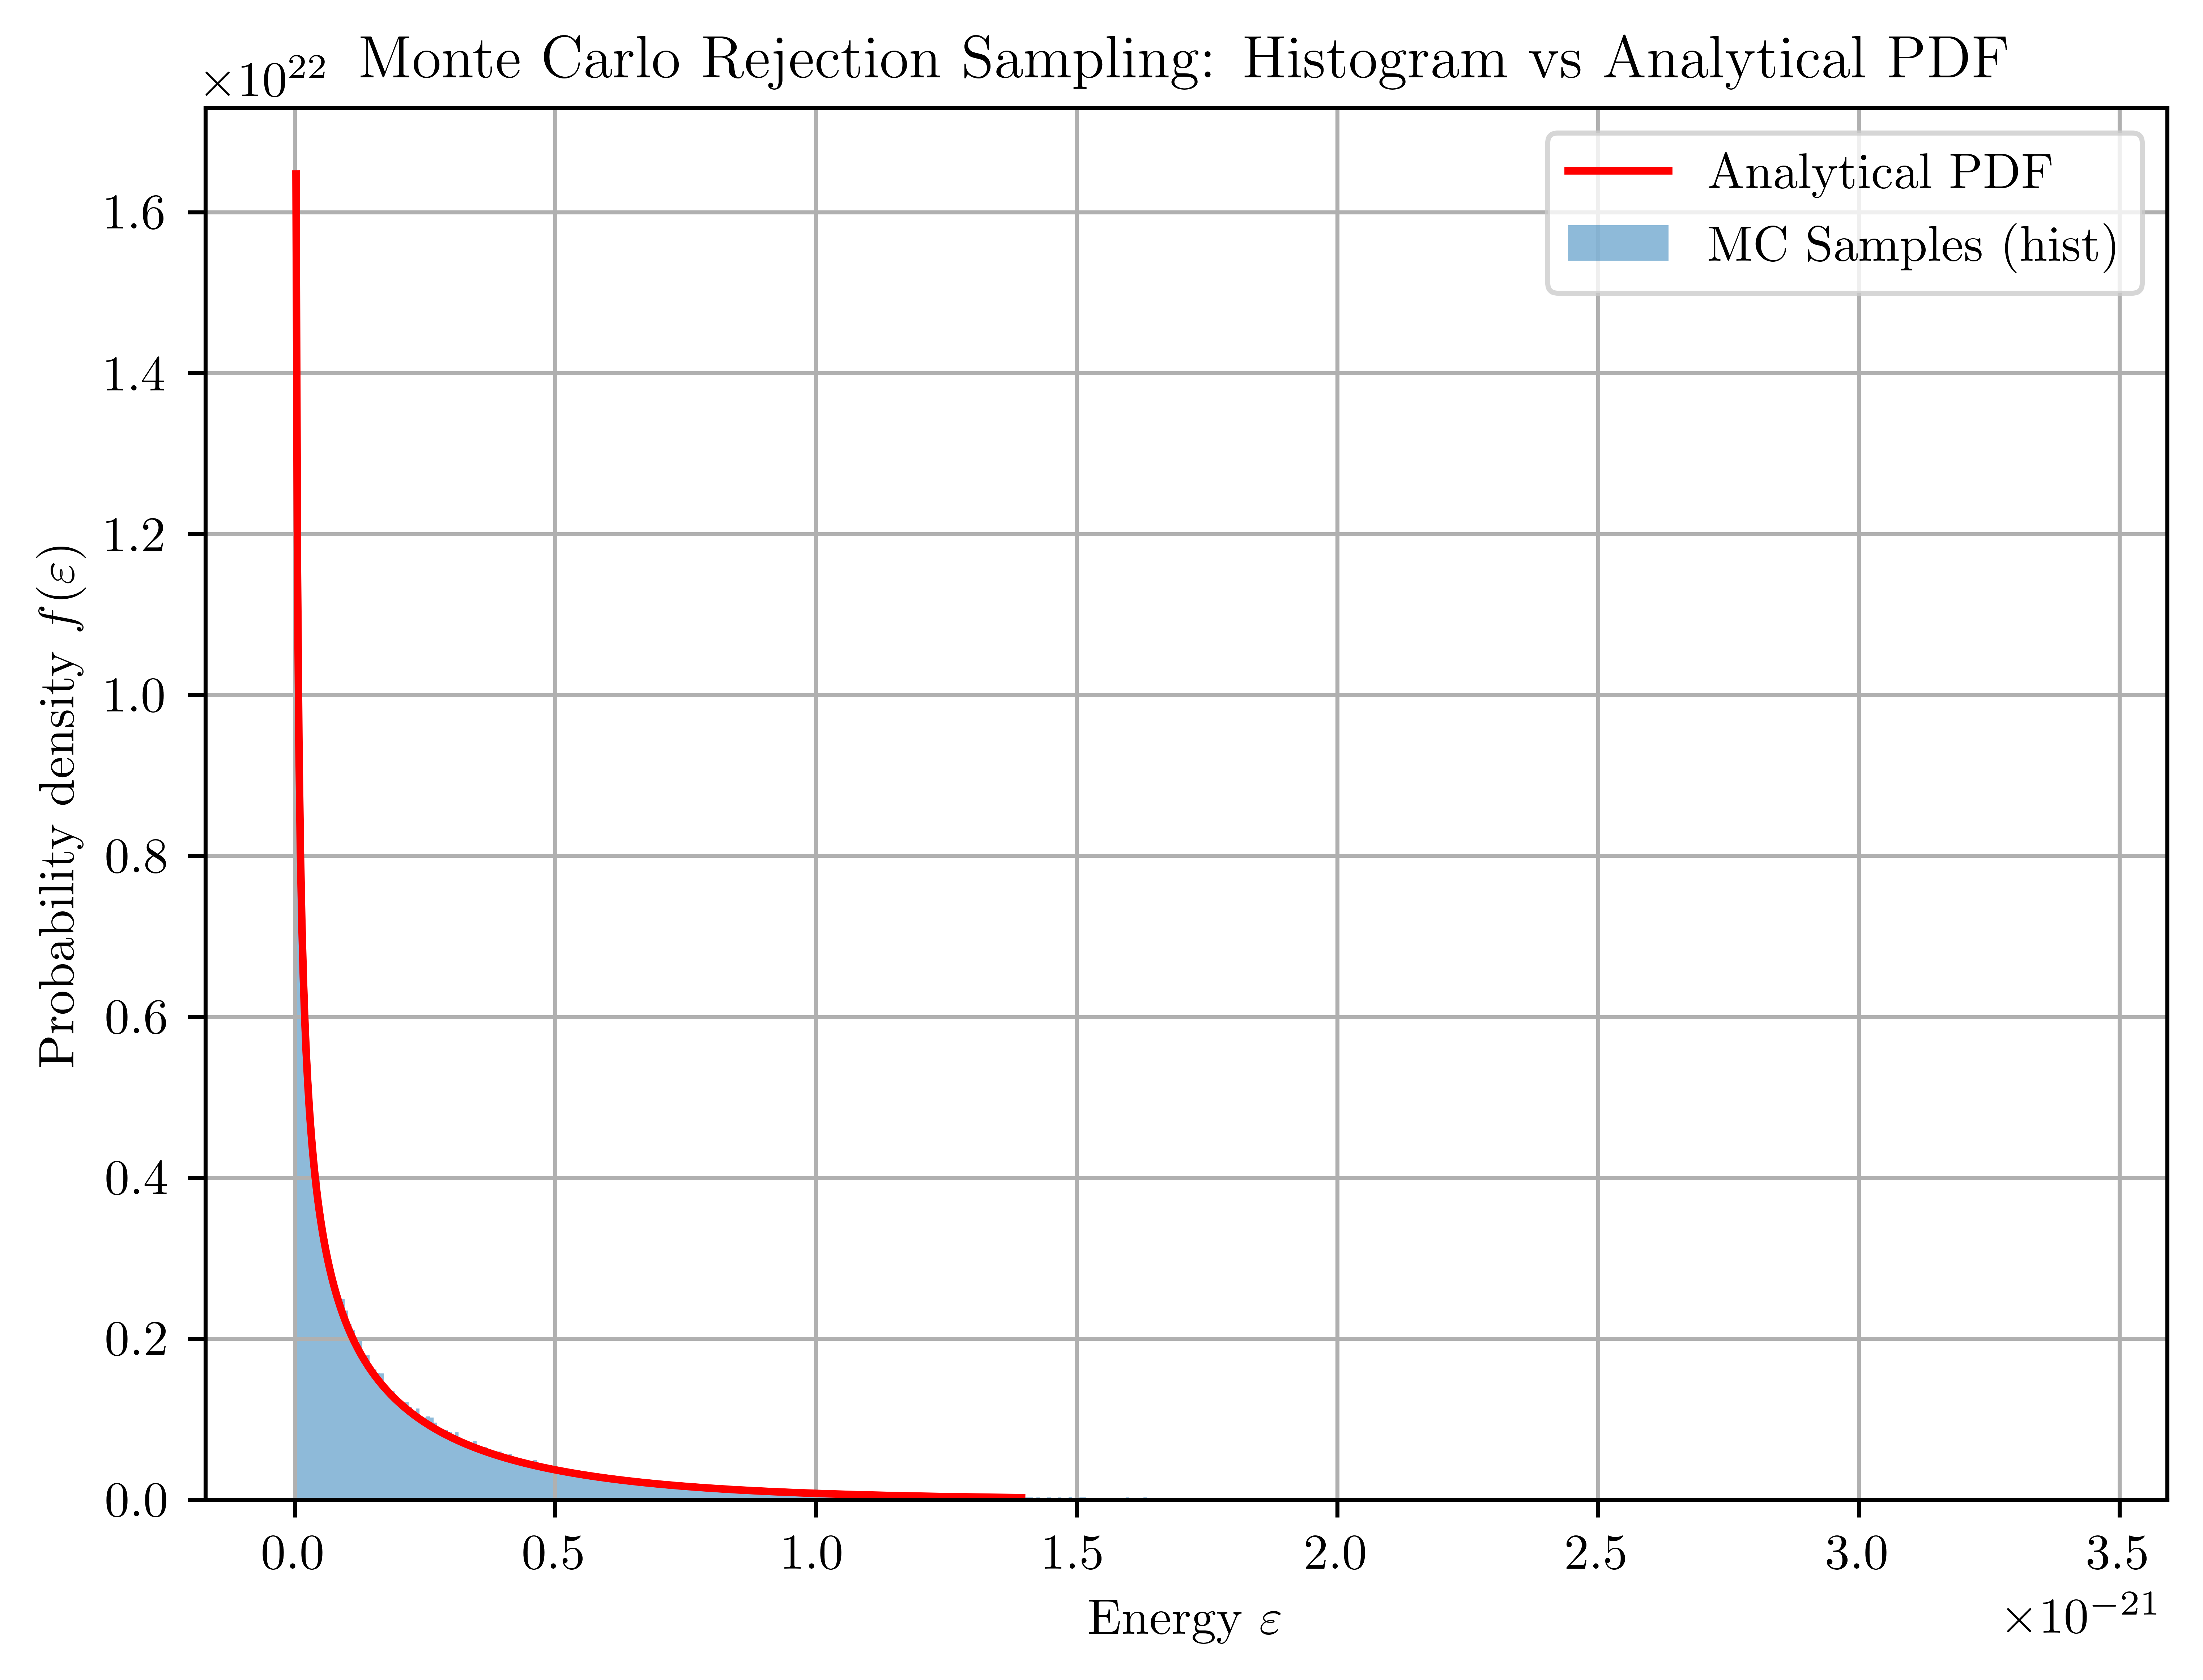

In [5]:
def target_pdf(eps, beta):
   
    A = np.sqrt(beta / math.pi)
    return A * np.exp(-beta * eps) / np.sqrt(eps)

def proposal_pdf(eps, lam):
    
    return lam * np.exp(-lam * eps)

def sample_from_proposal(lam, size):
    
    return np.random.exponential(1 / lam, size)

def rejection_sampling(N, beta, lam):
    
  
    eps_grid = np.linspace(1e-10, 10 / lam, 1000)  
    target_vals = target_pdf(eps_grid, beta)
    proposal_vals = np.maximum(proposal_pdf(eps_grid, lam), 1e-10)  
    
    ratio = target_vals / proposal_vals
    if np.any(np.isnan(ratio)) or np.any(np.isinf(ratio)):
        raise ValueError("Ratio contains NaN or infinite values.")

    M = 1.1 * np.max(ratio)  
    print(f"Calculated M: {M}")
    
    
    samples = []
    total_proposals = 0
    while len(samples) < N:
        eps_proposed = sample_from_proposal(lam, 1)[0]
        total_proposals += 1
        
        accept_prob = target_pdf(eps_proposed, beta) / (M * proposal_pdf(eps_proposed, lam))
        if np.random.rand() < accept_prob:
            samples.append(eps_proposed)
        
        
    
    efficiency = len(samples) / total_proposals
    print(f"Sampling Efficiency: {efficiency:.2%}")
    return np.array(samples)



lam = beta * 1.5  
N = 100000  


samples = rejection_sampling(N, beta, lam)


bins = 500
hist, bin_edges = np.histogram(samples, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


eps_grid = np.linspace(0, np.percentile(samples, 99.0), 500)
pdf_values = target_pdf(eps_grid, beta)

plt.figure(figsize=(7, 5), dpi=1000)
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label="MC Samples (hist)")
plt.plot(eps_grid, pdf_values, 'r-', label="Analytical PDF")
plt.xlabel(r"Energy $\varepsilon$")
plt.ylabel(r"Probability density $f(\varepsilon)$")
plt.title("Monte Carlo Rejection Sampling: Histogram vs Analytical PDF")
plt.legend()
plt.grid(True)
plt.savefig("monte_carlo_sampling.png")  
plt.show()

In [6]:

mean_samples = np.mean(rejection_sampling(N, beta, lam))
analytical_expectation_value = 0.5 * kb * T


    
    
print(f"Sample Mean <Ew>: {mean_samples:.5e} J")
print(f"Analytical Expectation Value: {analytical_expectation_value:.5e} J")


print(f"Relative Error: {abs(mean_samples - analytical_expectation_value) / analytical_expectation_value:.5e}")

Calculated M: 4.4917998085341875
Sampling Efficiency: 21.30%
Sample Mean <Ew>: 2.16014e-22 J
Analytical Expectation Value: 2.07090e-22 J
Relative Error: 4.30922e-02


In [ ]:
N = 1000000


def compute_statistics(samples):
    
    mean = np.mean(samples)  
    variance = np.var(samples)
    skewness = skew(samples)  
    kurt = kurtosis(samples, fisher=False)  
    
    return mean, variance, skewness, kurt

mean_Inverse, variance_Inverse, skewness_Inverse, kurt_Inverse = compute_statistics(sample_energy_inverse_transform(N, beta))

mean_Neumann, variance_Neumann, skewness_Neumann, kurt_Neumann = compute_statistics(rejection_sampling(N, beta, lam))


print(((kb*T)**2)/2)

print("For the Inverse Transform Method:")
print(f"Mean (⟨E⟩): {mean_Inverse:.5e} J")
print(f"Variance: {variance_Inverse:.5e} J^2")
print(f"Skewness: {skewness_Inverse:.5f}")
print(f"Kurtosis: {kurt_Inverse:.5f}\n\n")


print("For the Von Neumann method:")
print(f"Mean (⟨E⟩): {mean_Neumann:.5e} J")
print(f"Variance: {variance_Neumann:.5e} J^2")
print(f"Skewness: {skewness_Neumann:.5f}")
print(f"Kurtosis: {kurt_Neumann:.5f}")

Calculated M: 4.4917998085341875
Sampling Efficiency: 21.18%
8.577253619999998e-44
For the Inverse Transform Method:
Mean (⟨E⟩): 2.06756e-22 J
Variance: 8.59446e-44 J^2
Skewness: 2.85293
Kurtosis: 15.23417


For the Von Neumann method:
Mean (⟨E⟩): 2.17420e-22 J
Variance: 8.73766e-44 J^2
Skewness: 2.72023
Kurtosis: 13.71693


# Task 2 - Convergence

### a) Law of Large Numbers 

Take Nexp = 1 and show the law of large numbers based on the data points you generated.

2.0708999999999997e-22


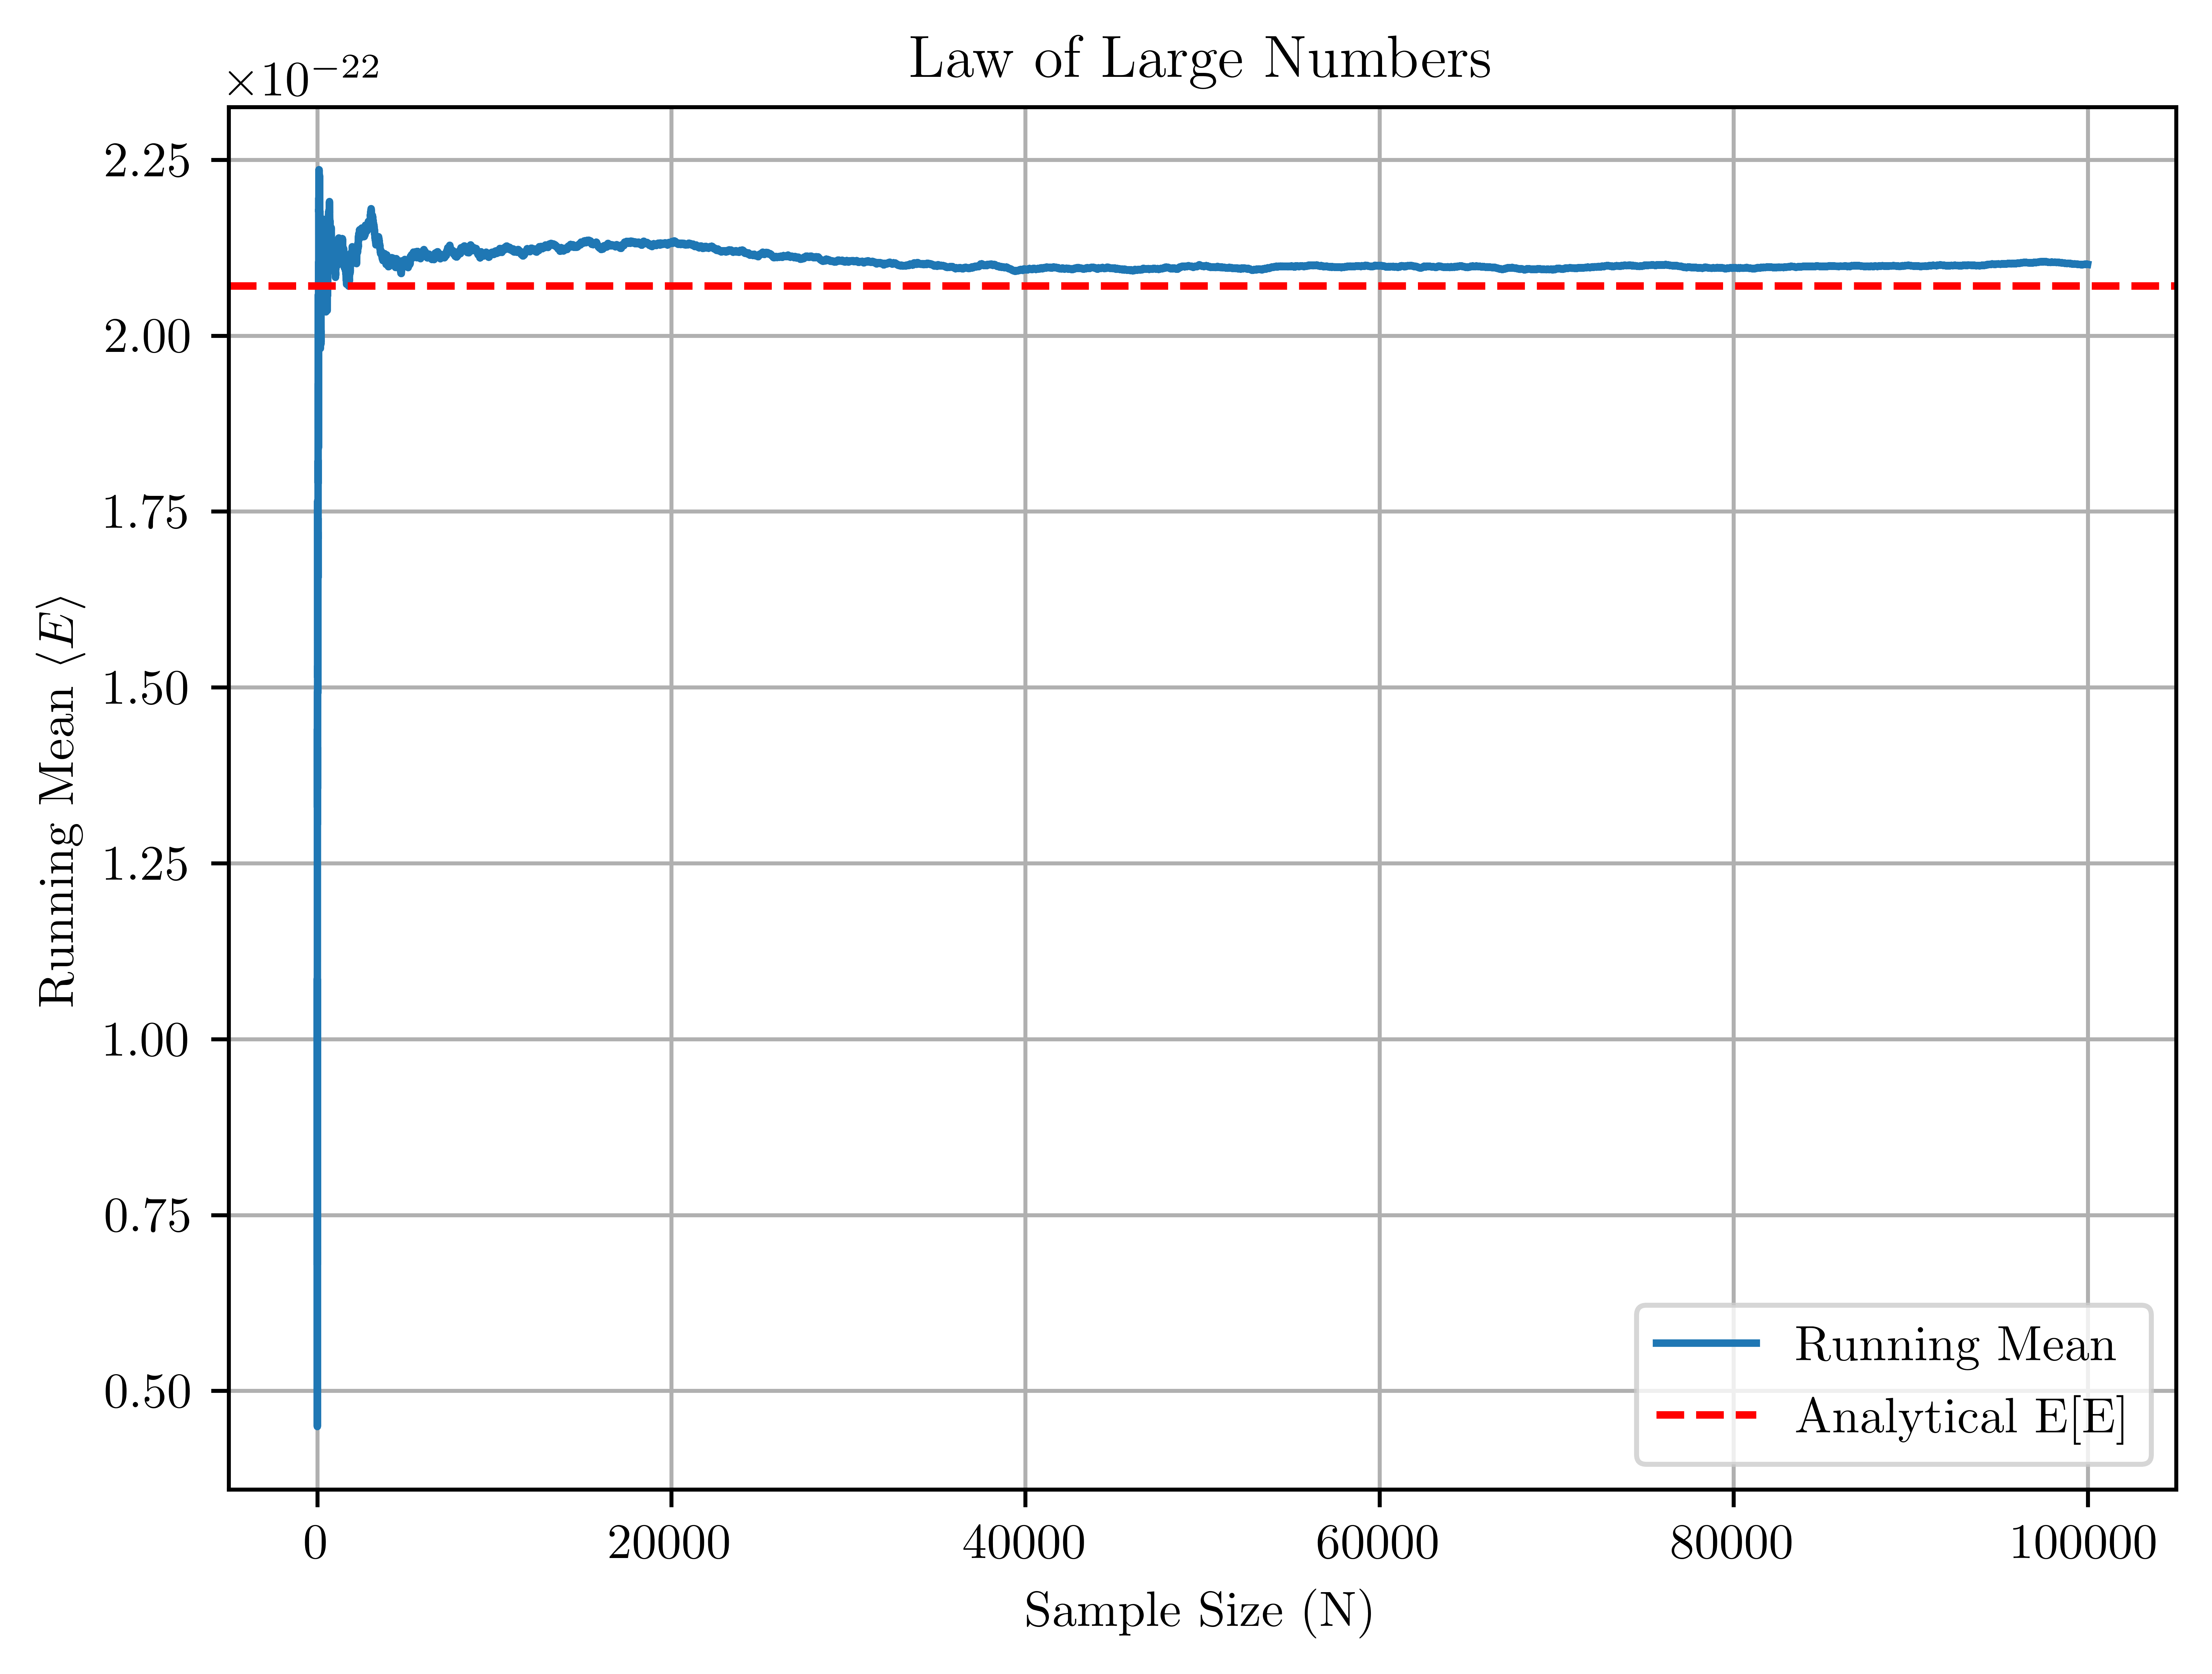

In [ ]:
def compute_expectation_and_variance(kb, T):
    
    expectation = 0.5 * kb * T  
    variance = ((kb*T)**2)/2  
    return expectation, variance



N=100000

expectation, variance = compute_expectation_and_variance(kb, T)

lam = beta * 1.5


samples = sample_energy_inverse_transform(N, beta)


running_mean = np.cumsum(samples) / np.arange(1, N + 1)
print(expectation)



plt.figure(figsize=(7, 5), dpi=1000)
plt.plot(np.arange(1, N + 1), running_mean, label="Running Mean")
plt.axhline(expectation, color="r", linestyle="--", label="Analytical E[E]")
plt.xlabel("Sample Size (N)")
plt.ylabel(r"Running Mean $\langle E \rangle$")
plt.title("Law of Large Numbers")
plt.legend()
plt.grid(True)
plt.show()

### b) Central Limit Theorem

Take Nexp >> 1 and show the validity of the central limit theorem for <E>.

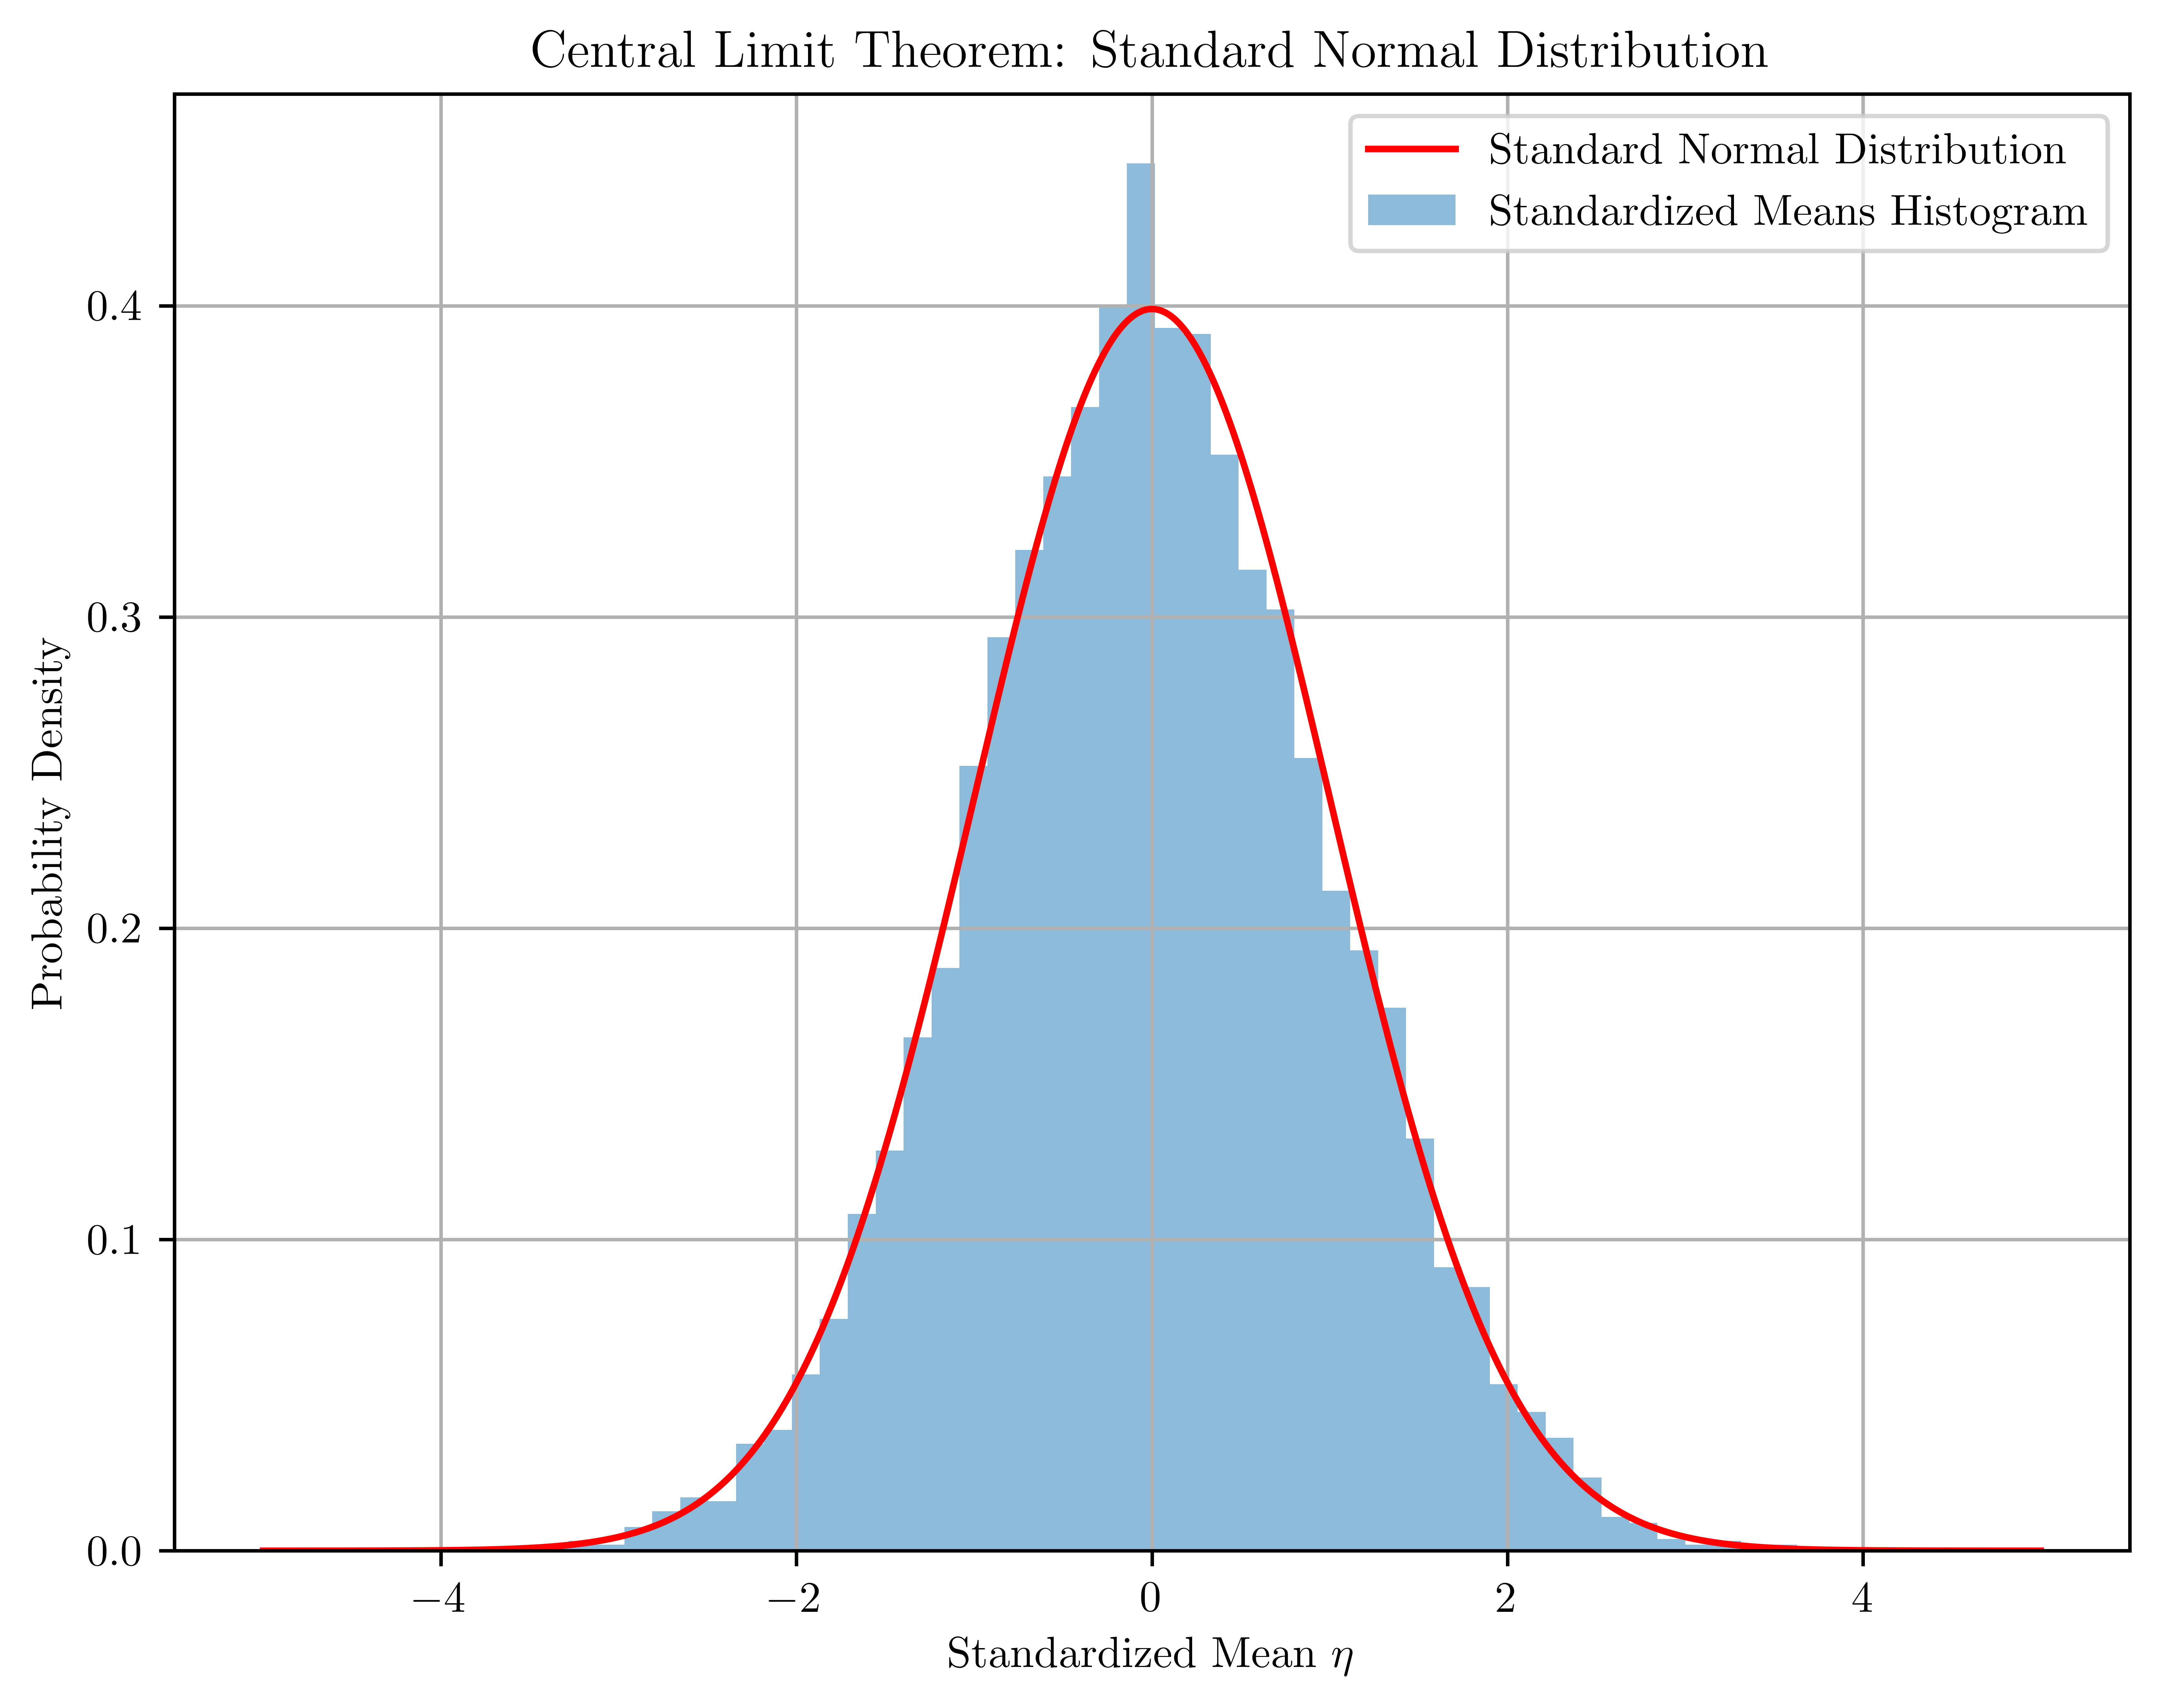

In [ ]:
sample_size=10000
N_exp=10000


CLT_means = [np.mean(sample_energy_inverse_transform(sample_size, beta)) for _ in range(N_exp)]


CLT_mean = np.mean(CLT_means)
CLT_var = np.var(CLT_means)


standardized_means = (CLT_means - CLT_mean) / np.sqrt(CLT_var)


hist, bin_edges = np.histogram(standardized_means, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


eta = np.linspace(-5, 5, 1000)  
gaussian_pdf = (1 / np.sqrt(2 * np.pi)) * np.exp(-(eta ** 2) / 2)


plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label='Standardized Means Histogram')
plt.plot(eta, gaussian_pdf, 'r-', label='Standard Normal Distribution')
plt.xlabel(r"Standardized Mean $\eta$")
plt.ylabel("Probability Density")
plt.title("Central Limit Theorem: Standard Normal Distribution")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
print(np.var(CLT_means))
print(np.var(standardized_means))

8.516219999687425e-48
1.0


## Task 3 - X^2 distribution

### a) Expected pdf

What is the expected p.d.f. for the number of entries per bin?

(100,)
(1000,)
(100,)
1000
100


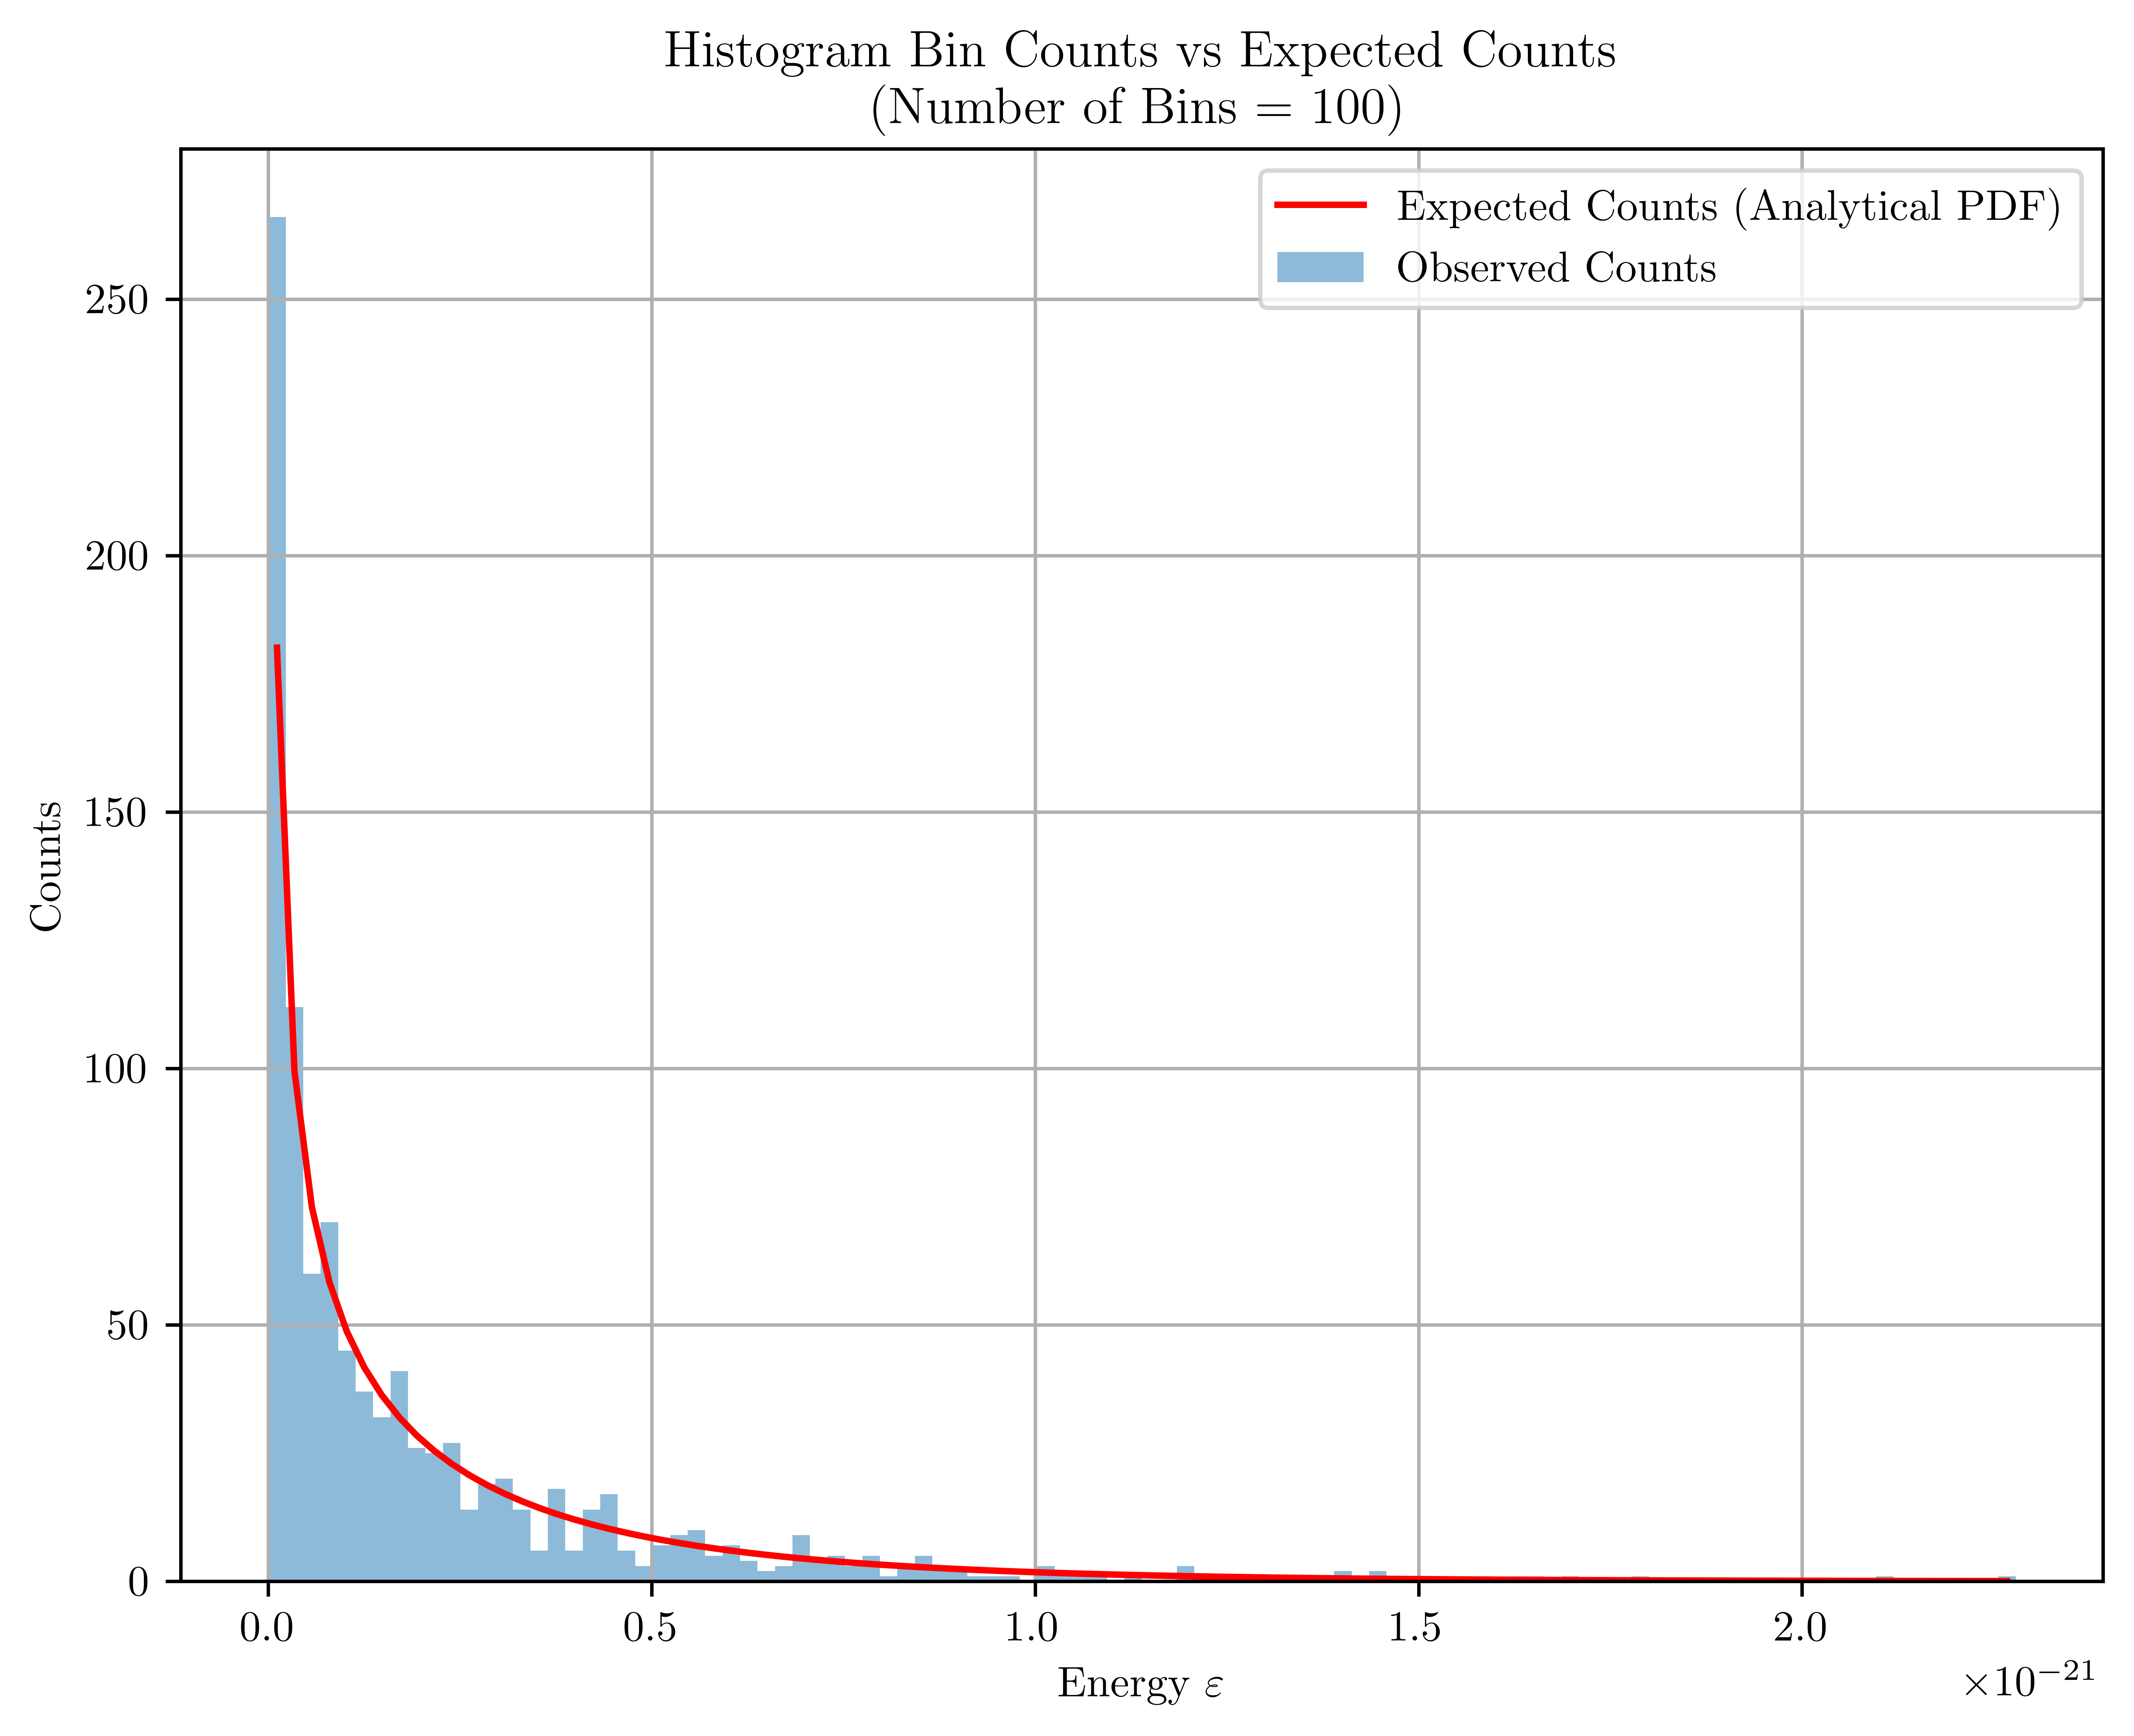

In [ ]:
N_exp = 1
N = 1000
bin = 100

energy_values = sample_energy_inverse_transform(N, beta)


hist, bin_edges = np.histogram(energy_values, bins=bin, range=(0, np.percentile(energy_values, 99.9)), density=False)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]  


print(bin_centers.shape)
expected_counts = pdf(bin_centers, beta) * bin_width * N

print(energy_values.shape)
print(expected_counts.shape)
print(len(energy_values))
print(len(expected_counts))

plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(bin_centers, hist, width=bin_width, alpha=0.5, label="Observed Counts")
plt.plot(bin_centers, expected_counts, 'r-', label="Expected Counts (Analytical PDF)")
plt.xlabel(r"Energy $\varepsilon$")
plt.ylabel("Counts")
plt.title(f"Histogram Bin Counts vs Expected Counts\n(Number of Bins = {bin})")
plt.legend()
plt.grid(True)
plt.show()


### b) Show distribution

Show that the  2 of the obtained entries per bin follows a  2 distribution. Instead of
calculating the empirical mean value per bin from the experiments, use the nominal value
from the p.d.f. formula per bin as the mean value per bin

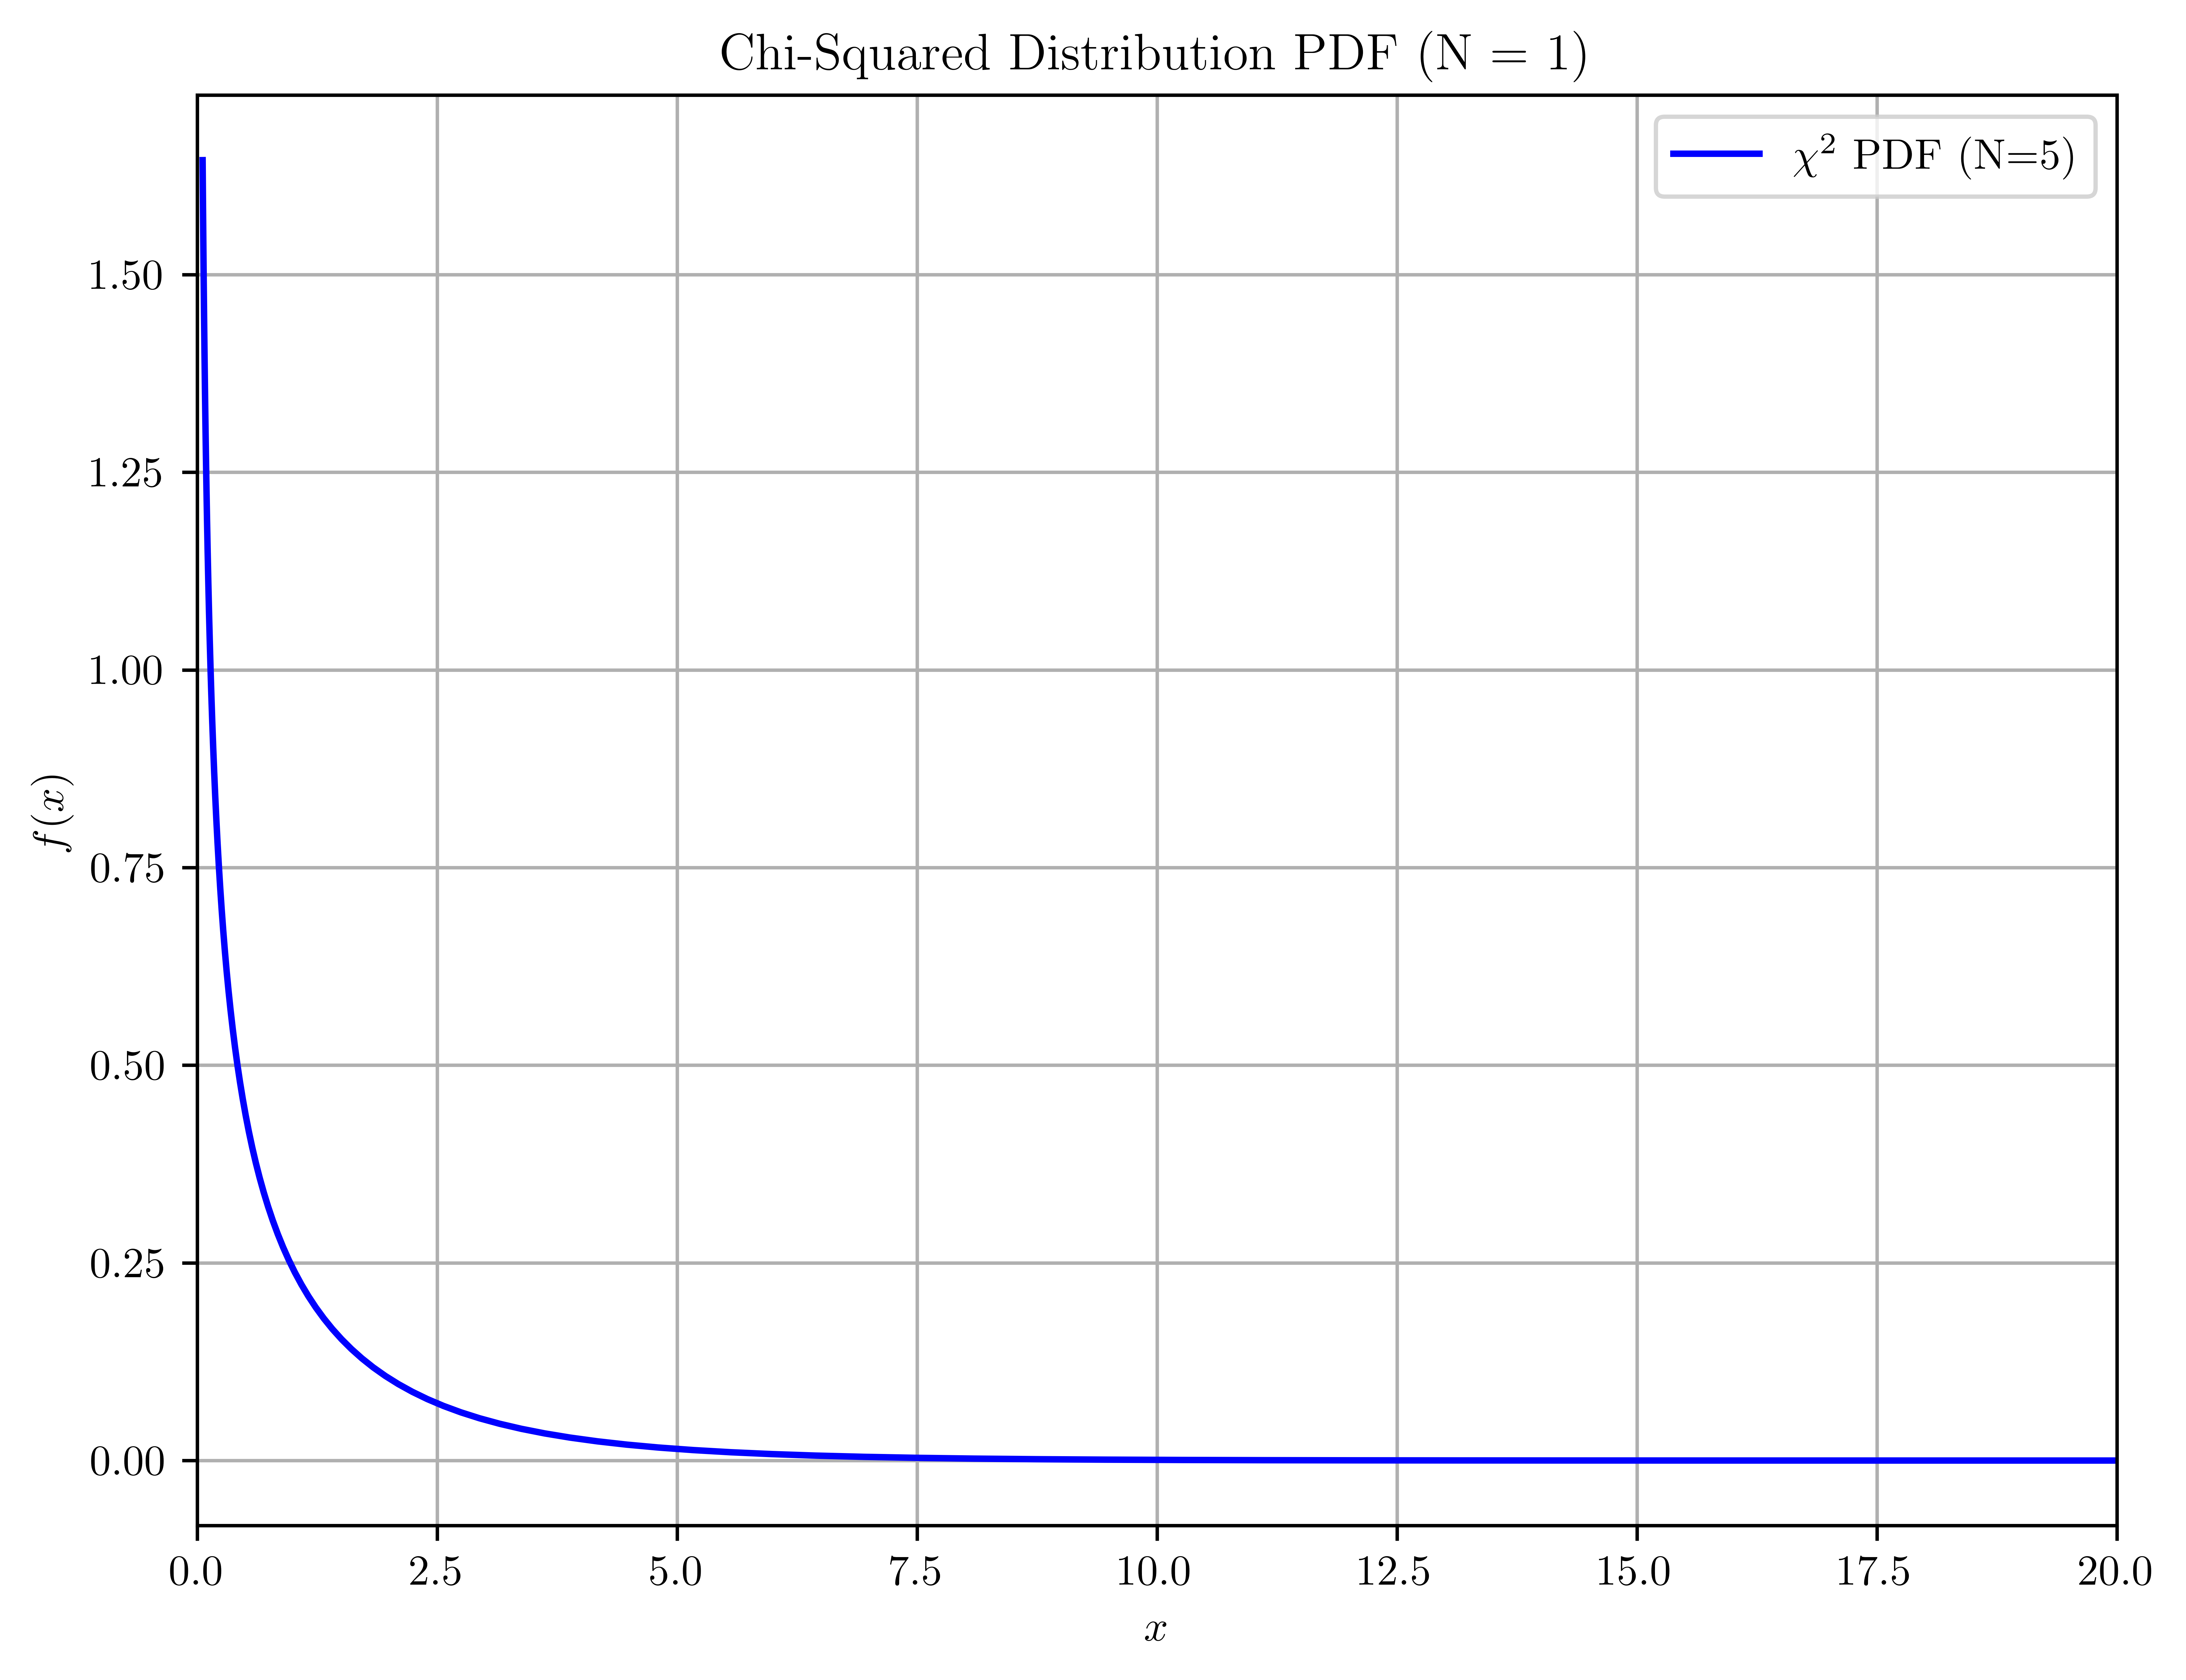

In [ ]:
def chi_squared_pdf(x, N):
   
    if N <= 0:
        raise ValueError("Degrees of freedom (N) must be a positive integer.")
    
    x = np.asarray(x)  
    pdf = np.zeros_like(x)  
    valid_indices = x > 0  
    pdf[valid_indices] = (
        (1 / (2 ** (N / 2) * gamma(N / 2))) * 
        (x[valid_indices] ** ((N / 2) - 1)) * 
        np.exp(-x[valid_indices] / 2)
    )
    return pdf


N = 1  

x = expected_counts

pdf_values = chi_squared_pdf(x, N)


plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(x, pdf_values, label=r"$\chi^2$ PDF (N=5)", color="blue")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(right=20)
plt.xlim(left=0)
plt.title(f"Chi-Squared Distribution PDF (N = {N})")
plt.legend()
plt.grid(True)
plt.show()

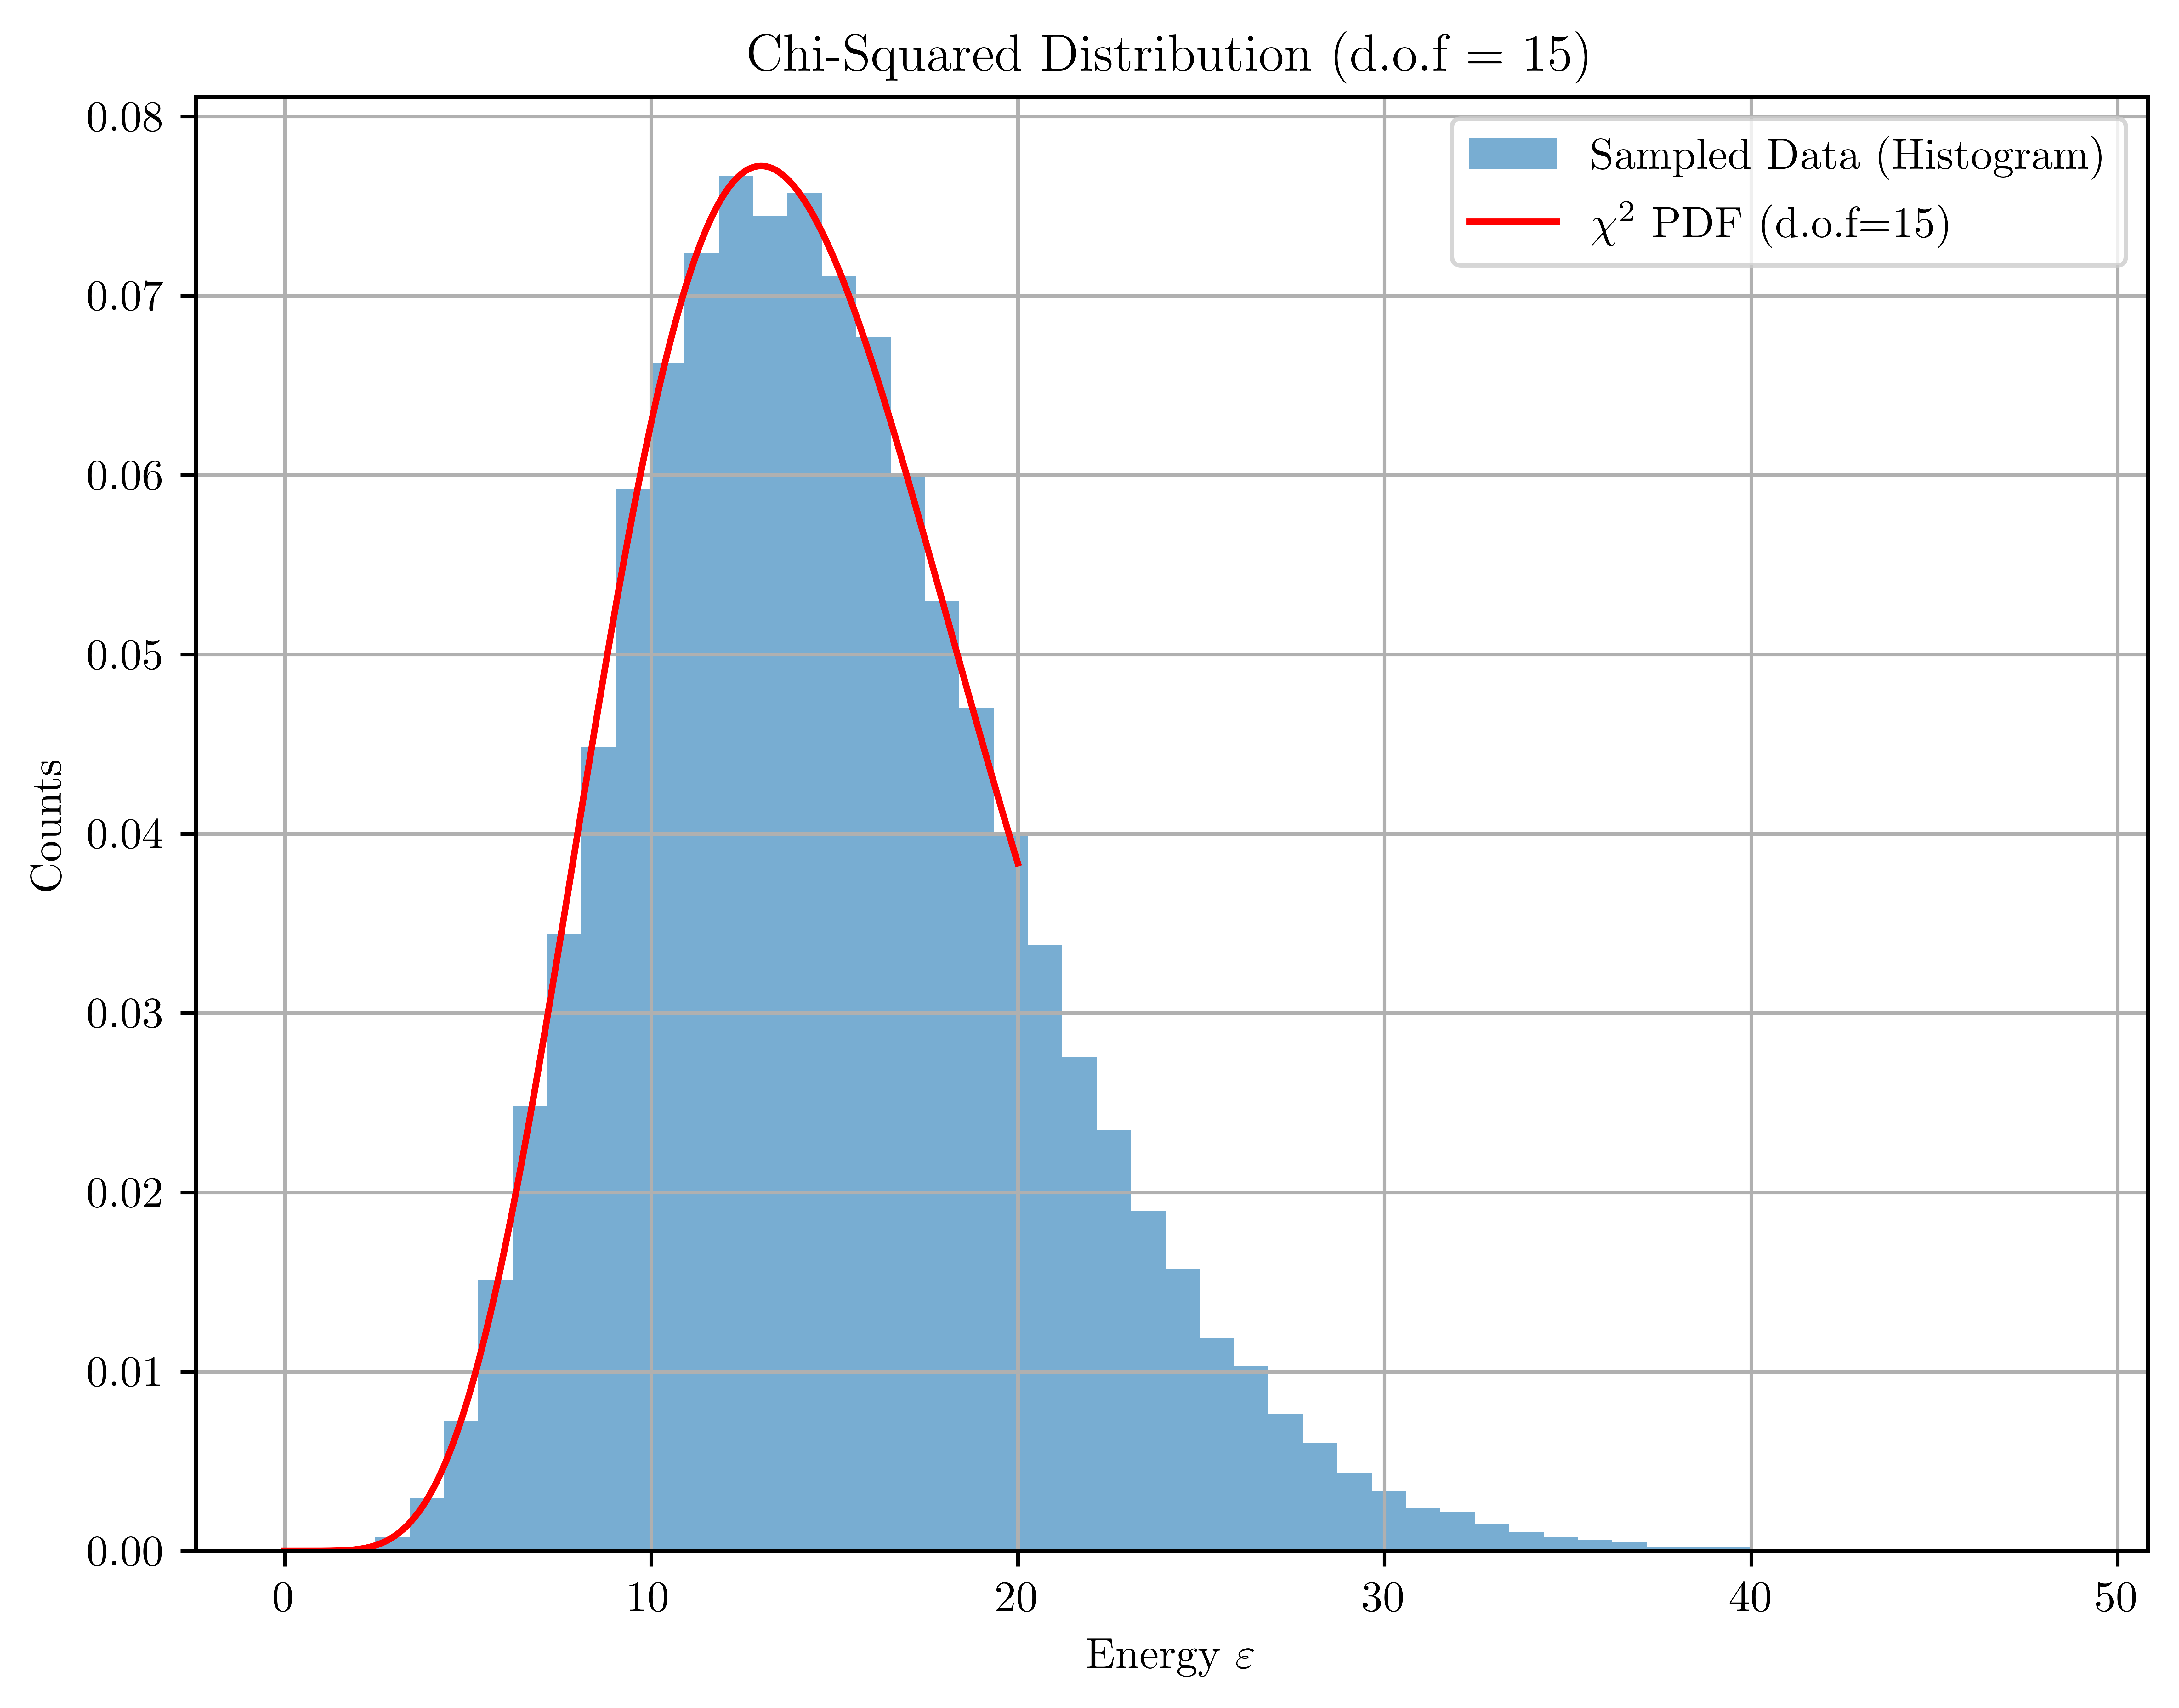

In [ ]:

def chi_squared_pdf(x, N):
   
    if N <= 0:
        raise ValueError("Degrees of freedom (N) must be a positive integer.")
    
    x = np.asarray(x)  
    pdf = np.zeros_like(x) 
    valid_indices = x > 0  
    pdf[valid_indices] = (
        (1 / (2 ** (N / 2) * gamma(N / 2))) * 
        (x[valid_indices] ** ((N / 2) - 1)) * 
        np.exp(-x[valid_indices] / 2)
    )
    return pdf


def sample_chi_squared(N_samples, N):
   
    return np.random.chisquare(N, N_samples)


N = 15  
N_samples = 100000  
bins = 50  


samples = sample_chi_squared(N_samples, N)


x = np.linspace(0, 20, 500) 
pdf_values = chi_squared_pdf(x, N)


plt.figure(figsize=(8, 6), dpi=1000)


plt.hist(samples, bins=bins, density=True, alpha=0.6, label="Sampled Data (Histogram)")


plt.plot(x, pdf_values, label=f"$\chi^2$ PDF (d.o.f={N})", color="red")


plt.xlabel(r"Energy $\varepsilon$")
plt.ylabel("Counts")
plt.title(f"Chi-Squared Distribution (d.o.f = {N})")
plt.legend()
plt.grid(True)
plt.show()

## Task 4 - Parameter estimation

a) Compute the log likelihood ln L(E!,1, E!,2, ..., E!,N | T ) at a given T . Then, use the
maximum likelihood method to estimate T and its variance.

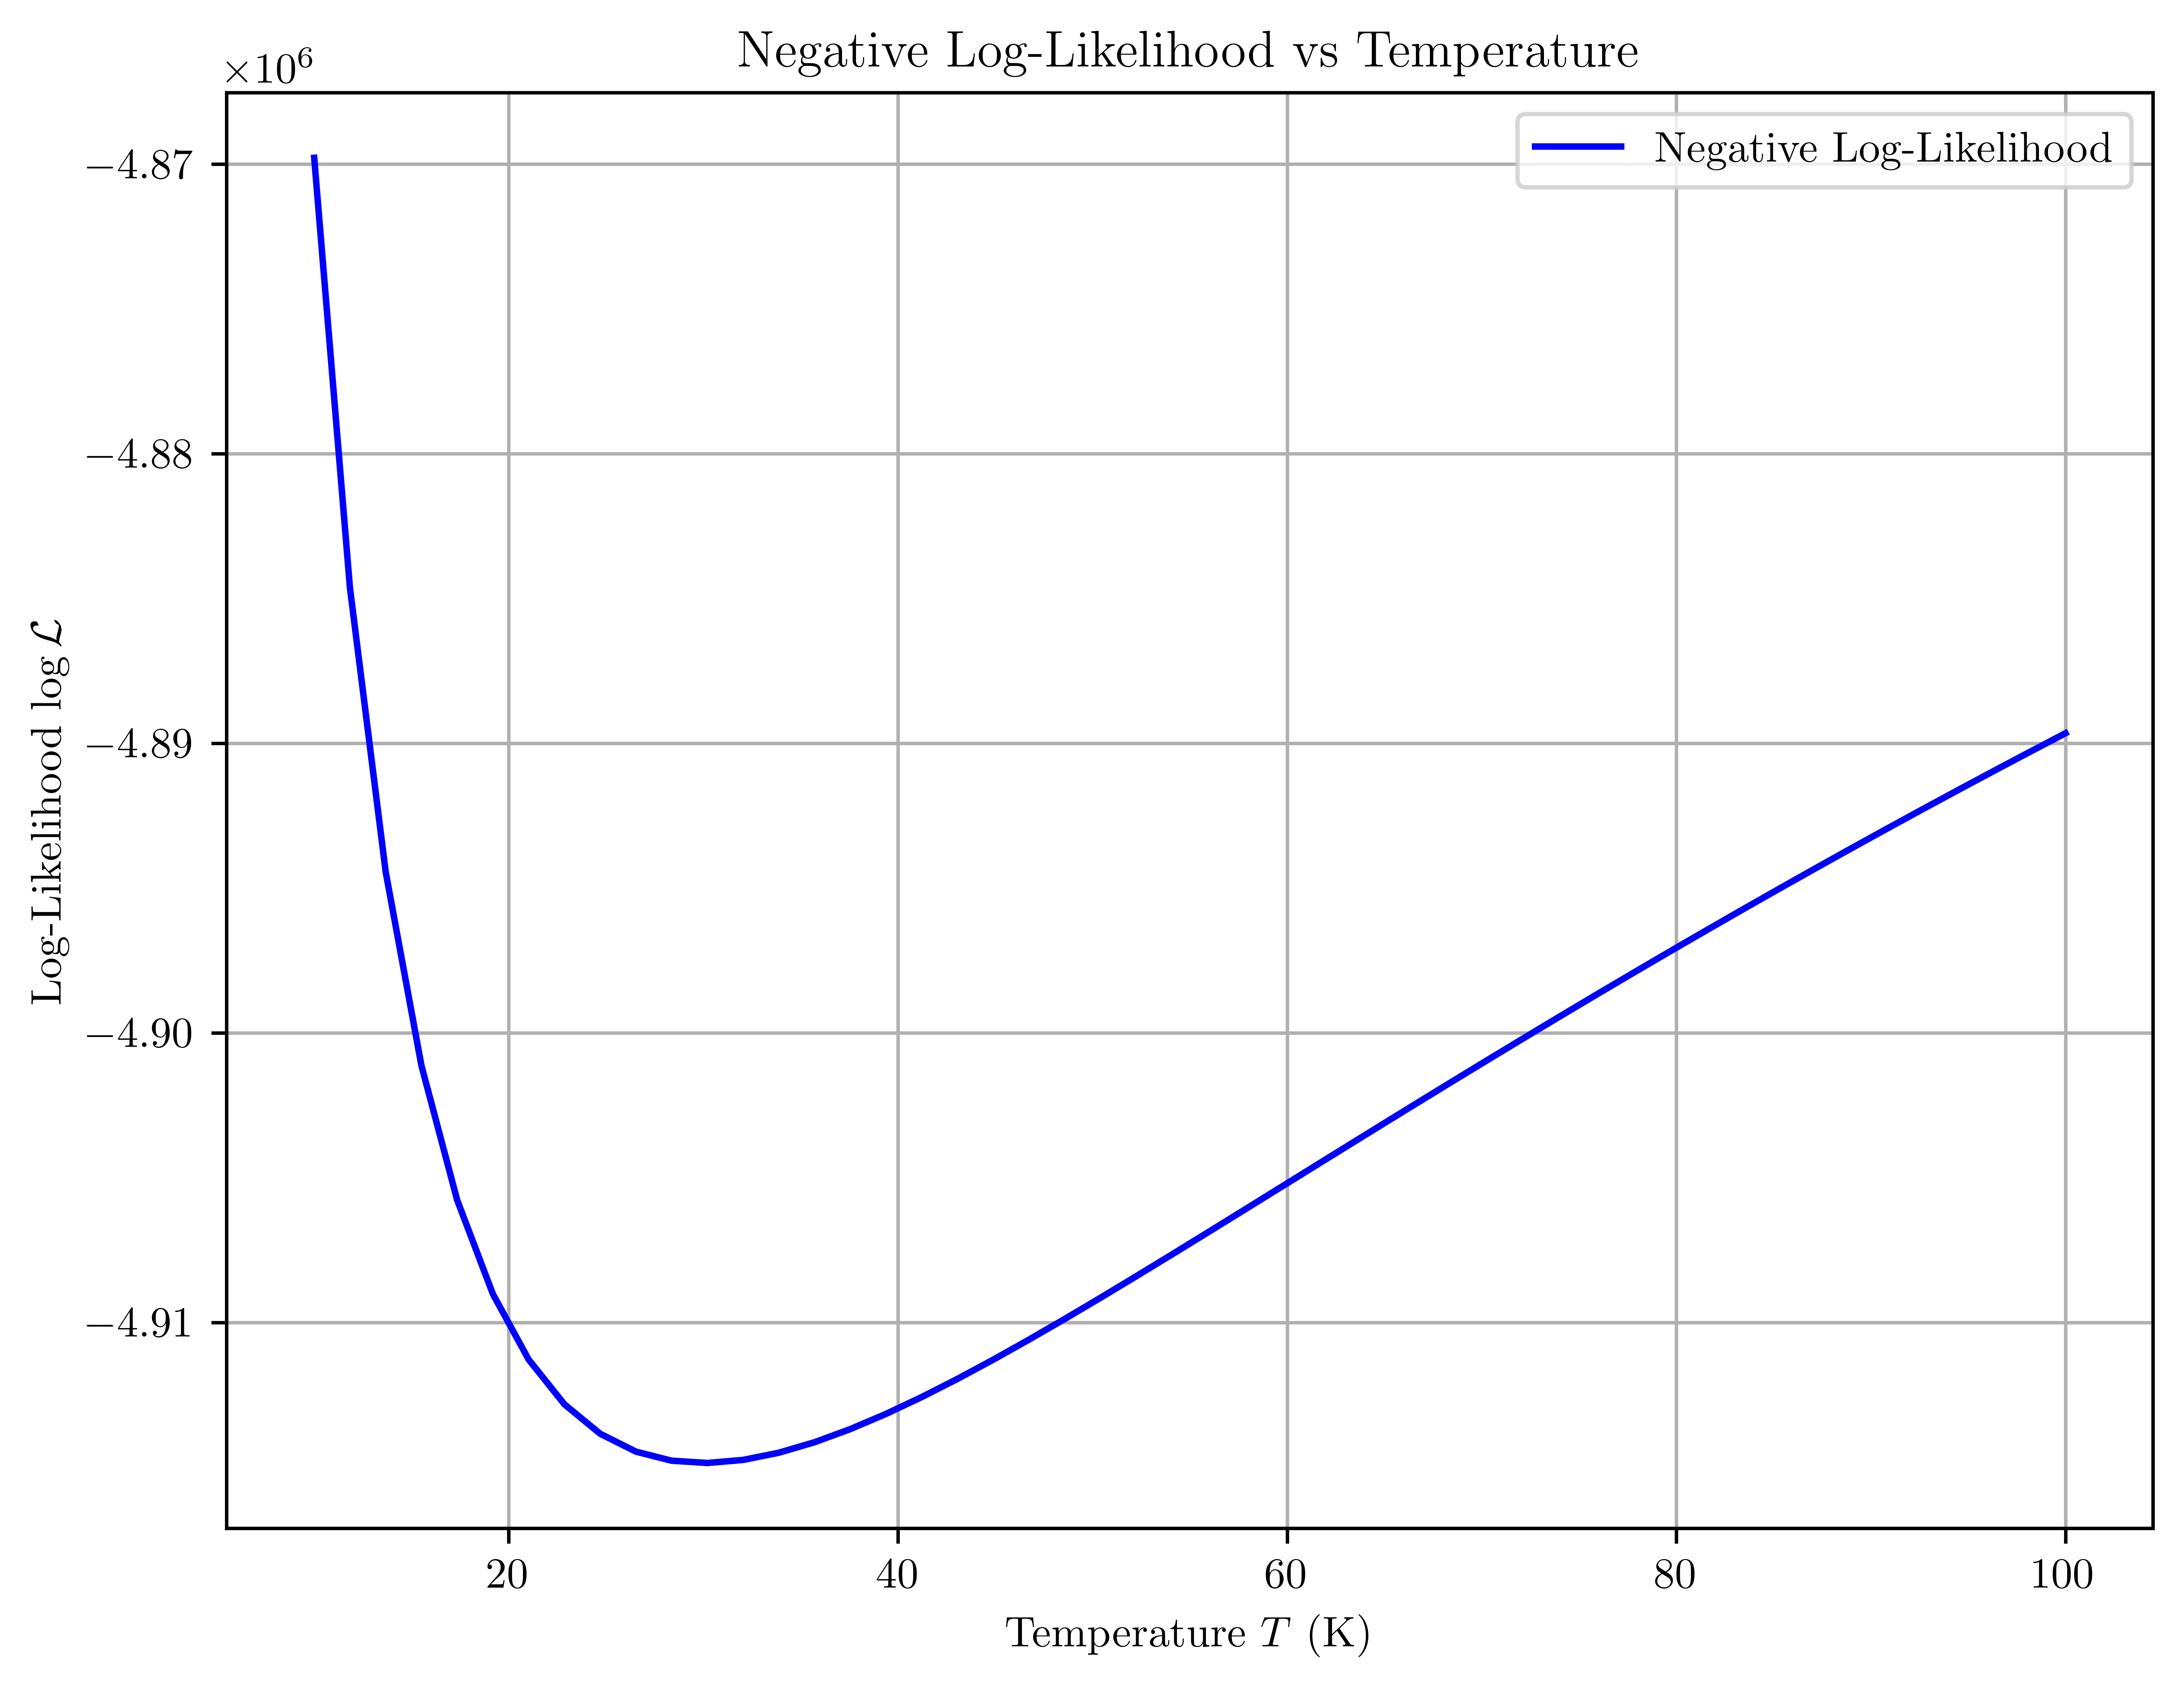

In [ ]:
T_ref = 30  

k_B = 1.3806e-23  
beta_ref = 1 / (k_B * T_ref)
N = 100000  

T_values = np.linspace(10, 100, 50) 
log_likelihoods = []



def compute_log_likelihood(data, beta):
  
    valid_data = data[data > 0]  

    if len(valid_data) == 0:
        raise ValueError("No valid (positive) data points to compute the log-likelihood.")
    
    
    log_pdf_values = (
        np.log(np.sqrt(beta / np.pi)) - beta * valid_data - 0.5 * np.log(valid_data)
    )
    
    
    return np.sum(log_pdf_values)





energy_samples = sample_energy_inverse_transform(N, beta_ref)





for T in T_values:
    beta = 1 / (k_B * T)
    log_likelihood = compute_log_likelihood(energy_samples, beta)
    log_likelihoods.append(-log_likelihood)


plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(T_values, log_likelihoods, label="Negative Log-Likelihood", color="blue")
plt.xlabel(r"Temperature $T$ (K)")
plt.ylabel(r"Log-Likelihood $\log \mathcal{L}$")
plt.title("Negative Log-Likelihood vs Temperature")
plt.legend()
plt.grid(True)
plt.show()


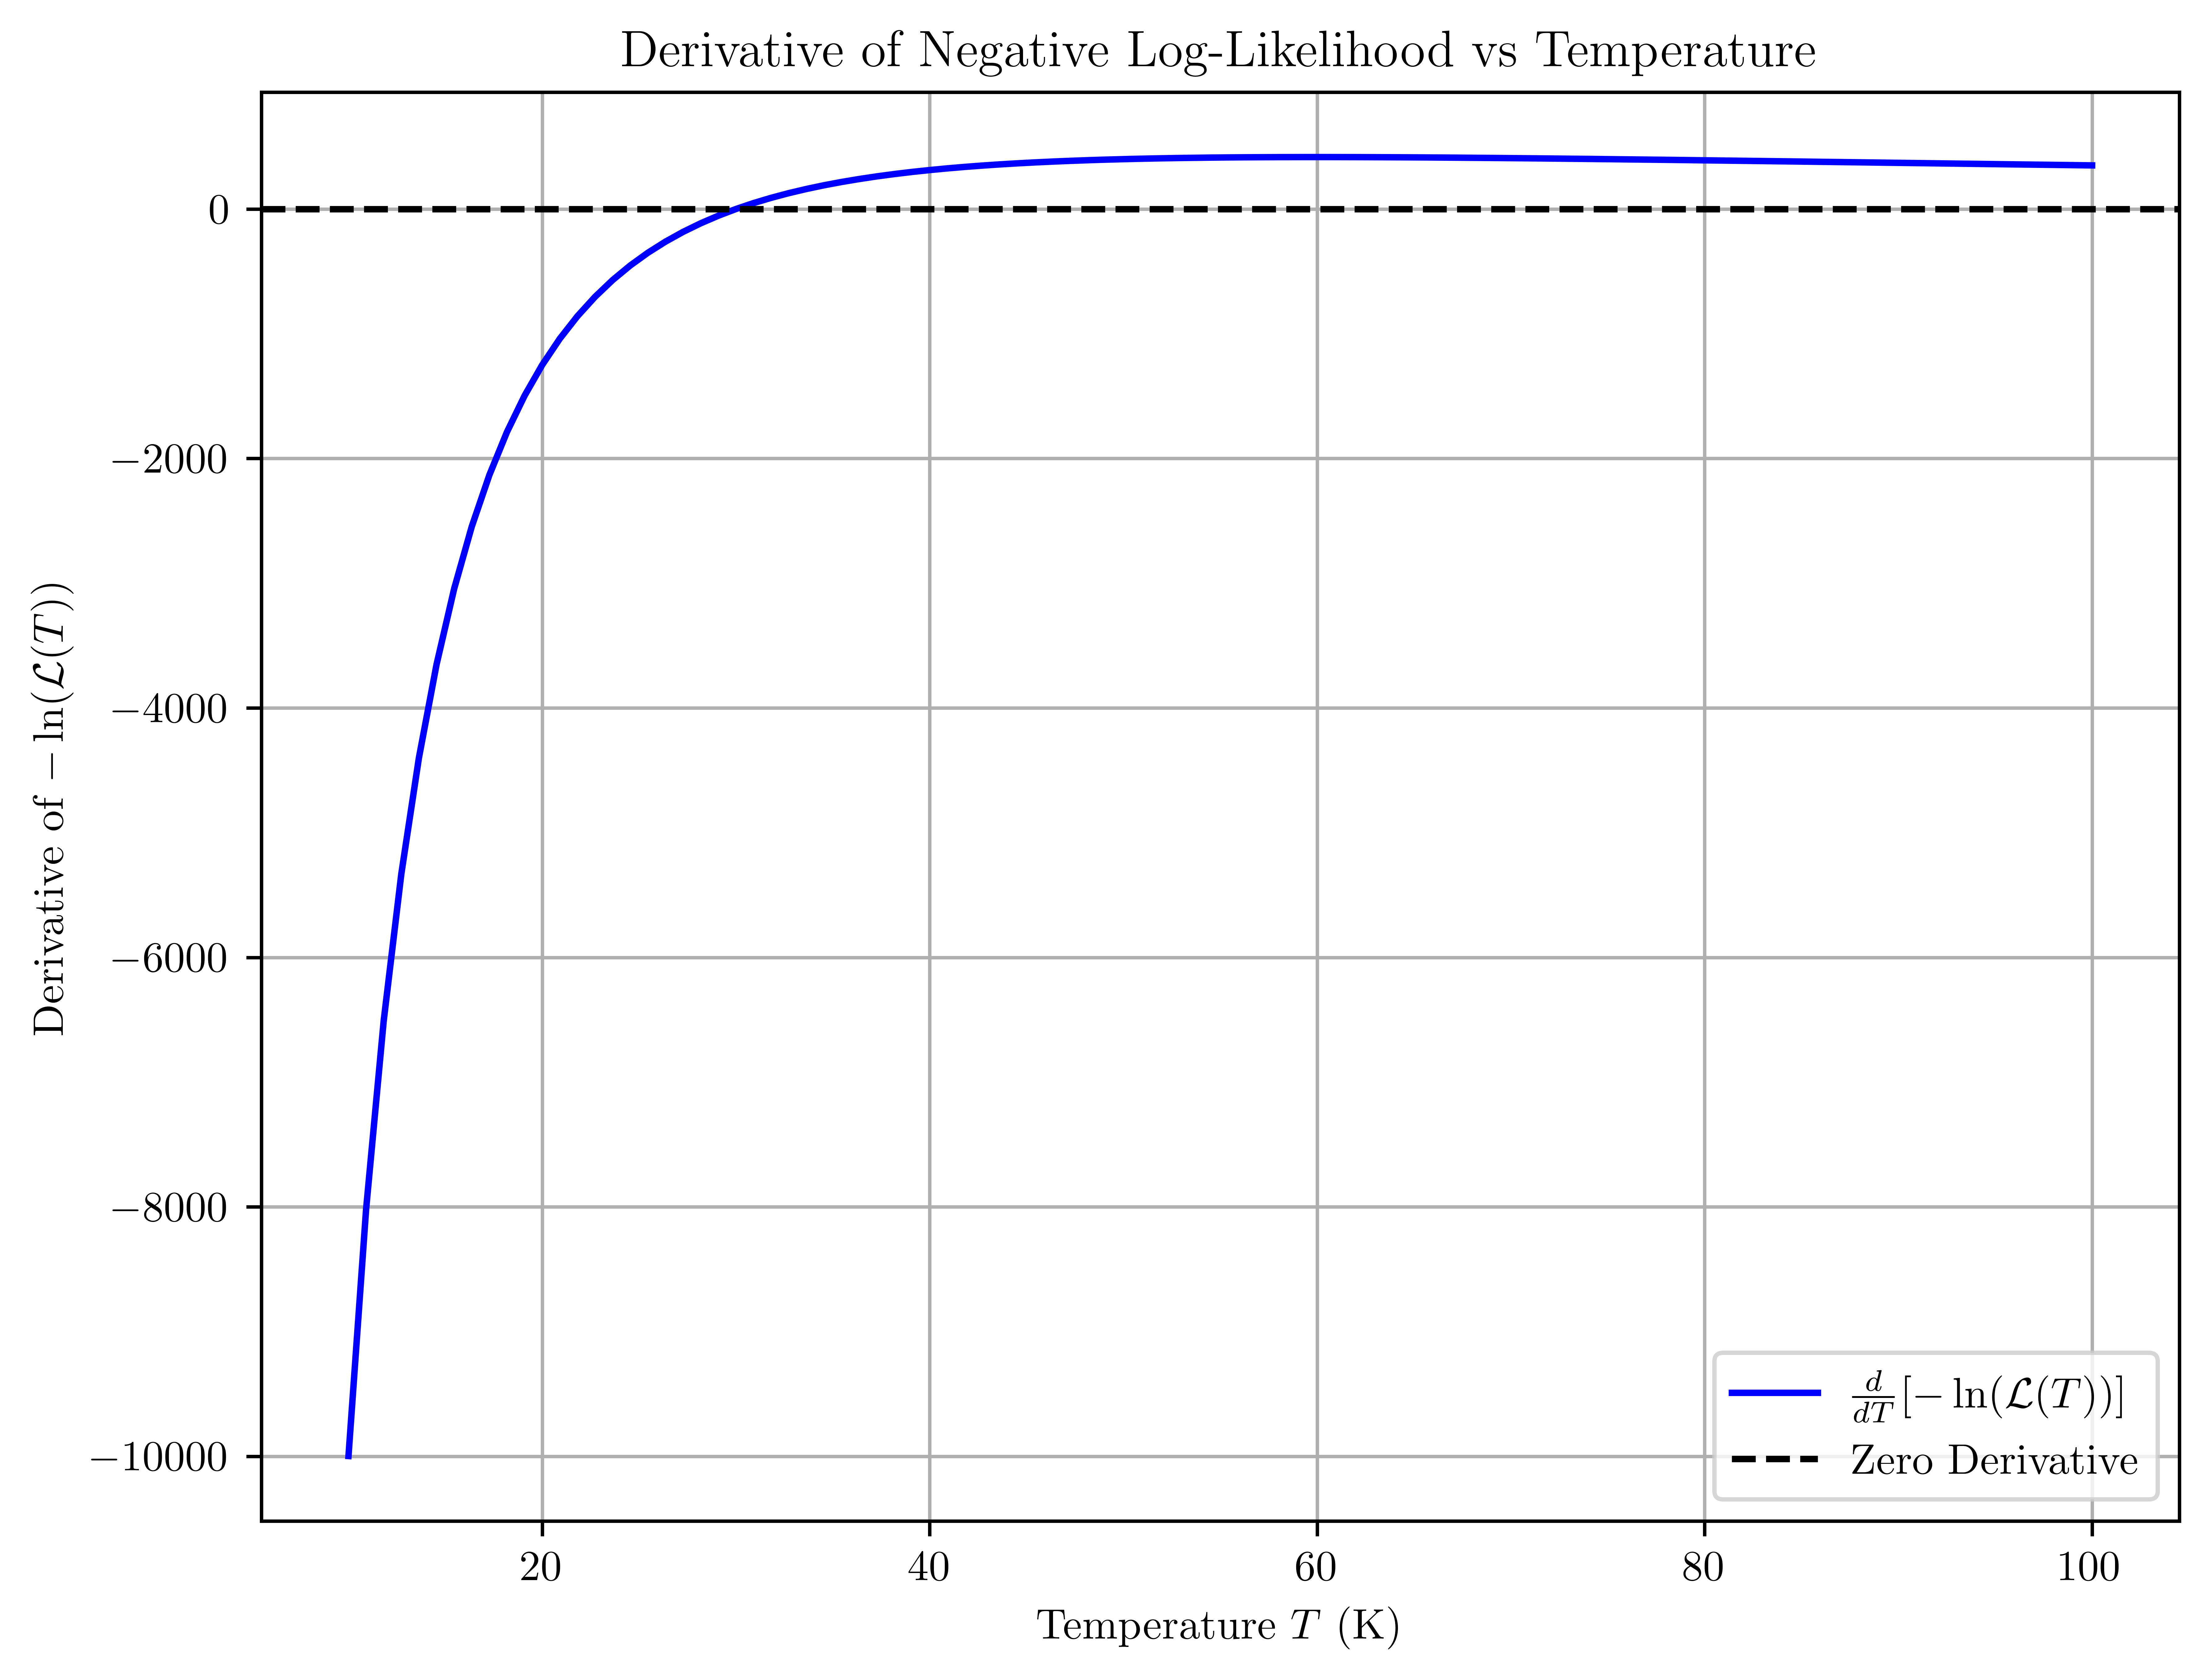

In [ ]:

def derivative_negative_log_likelihood(data, T, k_B):
    if T <= 0:
        raise ValueError("Temperature T must be greater than zero.")
    if np.any(data <= 0):
        raise ValueError("All data points must be positive.")
    
    derivative = np.sum((1 / (2 * T)) - (data / (k_B * T**2)))
    return derivative

N = 100000  
T_values = np.linspace(10, 100, 100)  


T_ref = 30  
beta_ref = 1 / (k_B * T_ref)
energy_samples = sample_energy_inverse_transform(N, beta_ref)

derivatives = []
for T in T_values:
    derivative = derivative_negative_log_likelihood(energy_samples, T, k_B)
    derivatives.append(derivative)


plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(T_values, derivatives, label=r"$\frac{d}{dT}[-\ln(\mathcal{L}(T))]$", color="blue")

plt.axhline(0, color="black", linestyle="--", label="Zero Derivative")

plt.xlabel(r"Temperature $T$ (K)")
plt.ylabel(r"Derivative of $-\ln(\mathcal{L}(T))$")
plt.title("Derivative of Negative Log-Likelihood vs Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def root_function(T):
    return derivative_negative_log_likelihood(energy_samples, T, k_B)


result = root_scalar(root_function, bracket=[10, 100], method='brentq')

if result.converged:
    T_MLE = result.root
    print(f"The maximum likelihood estimate (T_MLE) is: {T_MLE:.5f} K")
else:
    print("Root-finding did not converge.")

The maximum likelihood estimate (T_MLE) is: 29.99649 K


In [17]:
def sample_variance(data):
   
    mean_x = np.mean(data)
    variance = np.sum((data - mean_x) ** 2) / len(data)
    return variance


variance_of_energy_samples = sample_variance(energy_samples)
print(f"Sample Variance of Energy: {variance_of_energy_samples:.5e} J^2")


variance_T_MLE = variance_of_energy_samples / (k_B * T_MLE**2)
print(f"Estimated Variance of T_MLE: {variance_T_MLE:.5e} K^2")

Sample Variance of Energy: 8.61890e-44 J^2
Estimated Variance of T_MLE: 6.93814e-24 K^2


Least Squares Estimate of T (T_best): 26.89560 K
Variance of T_best: 0.00544 K^2


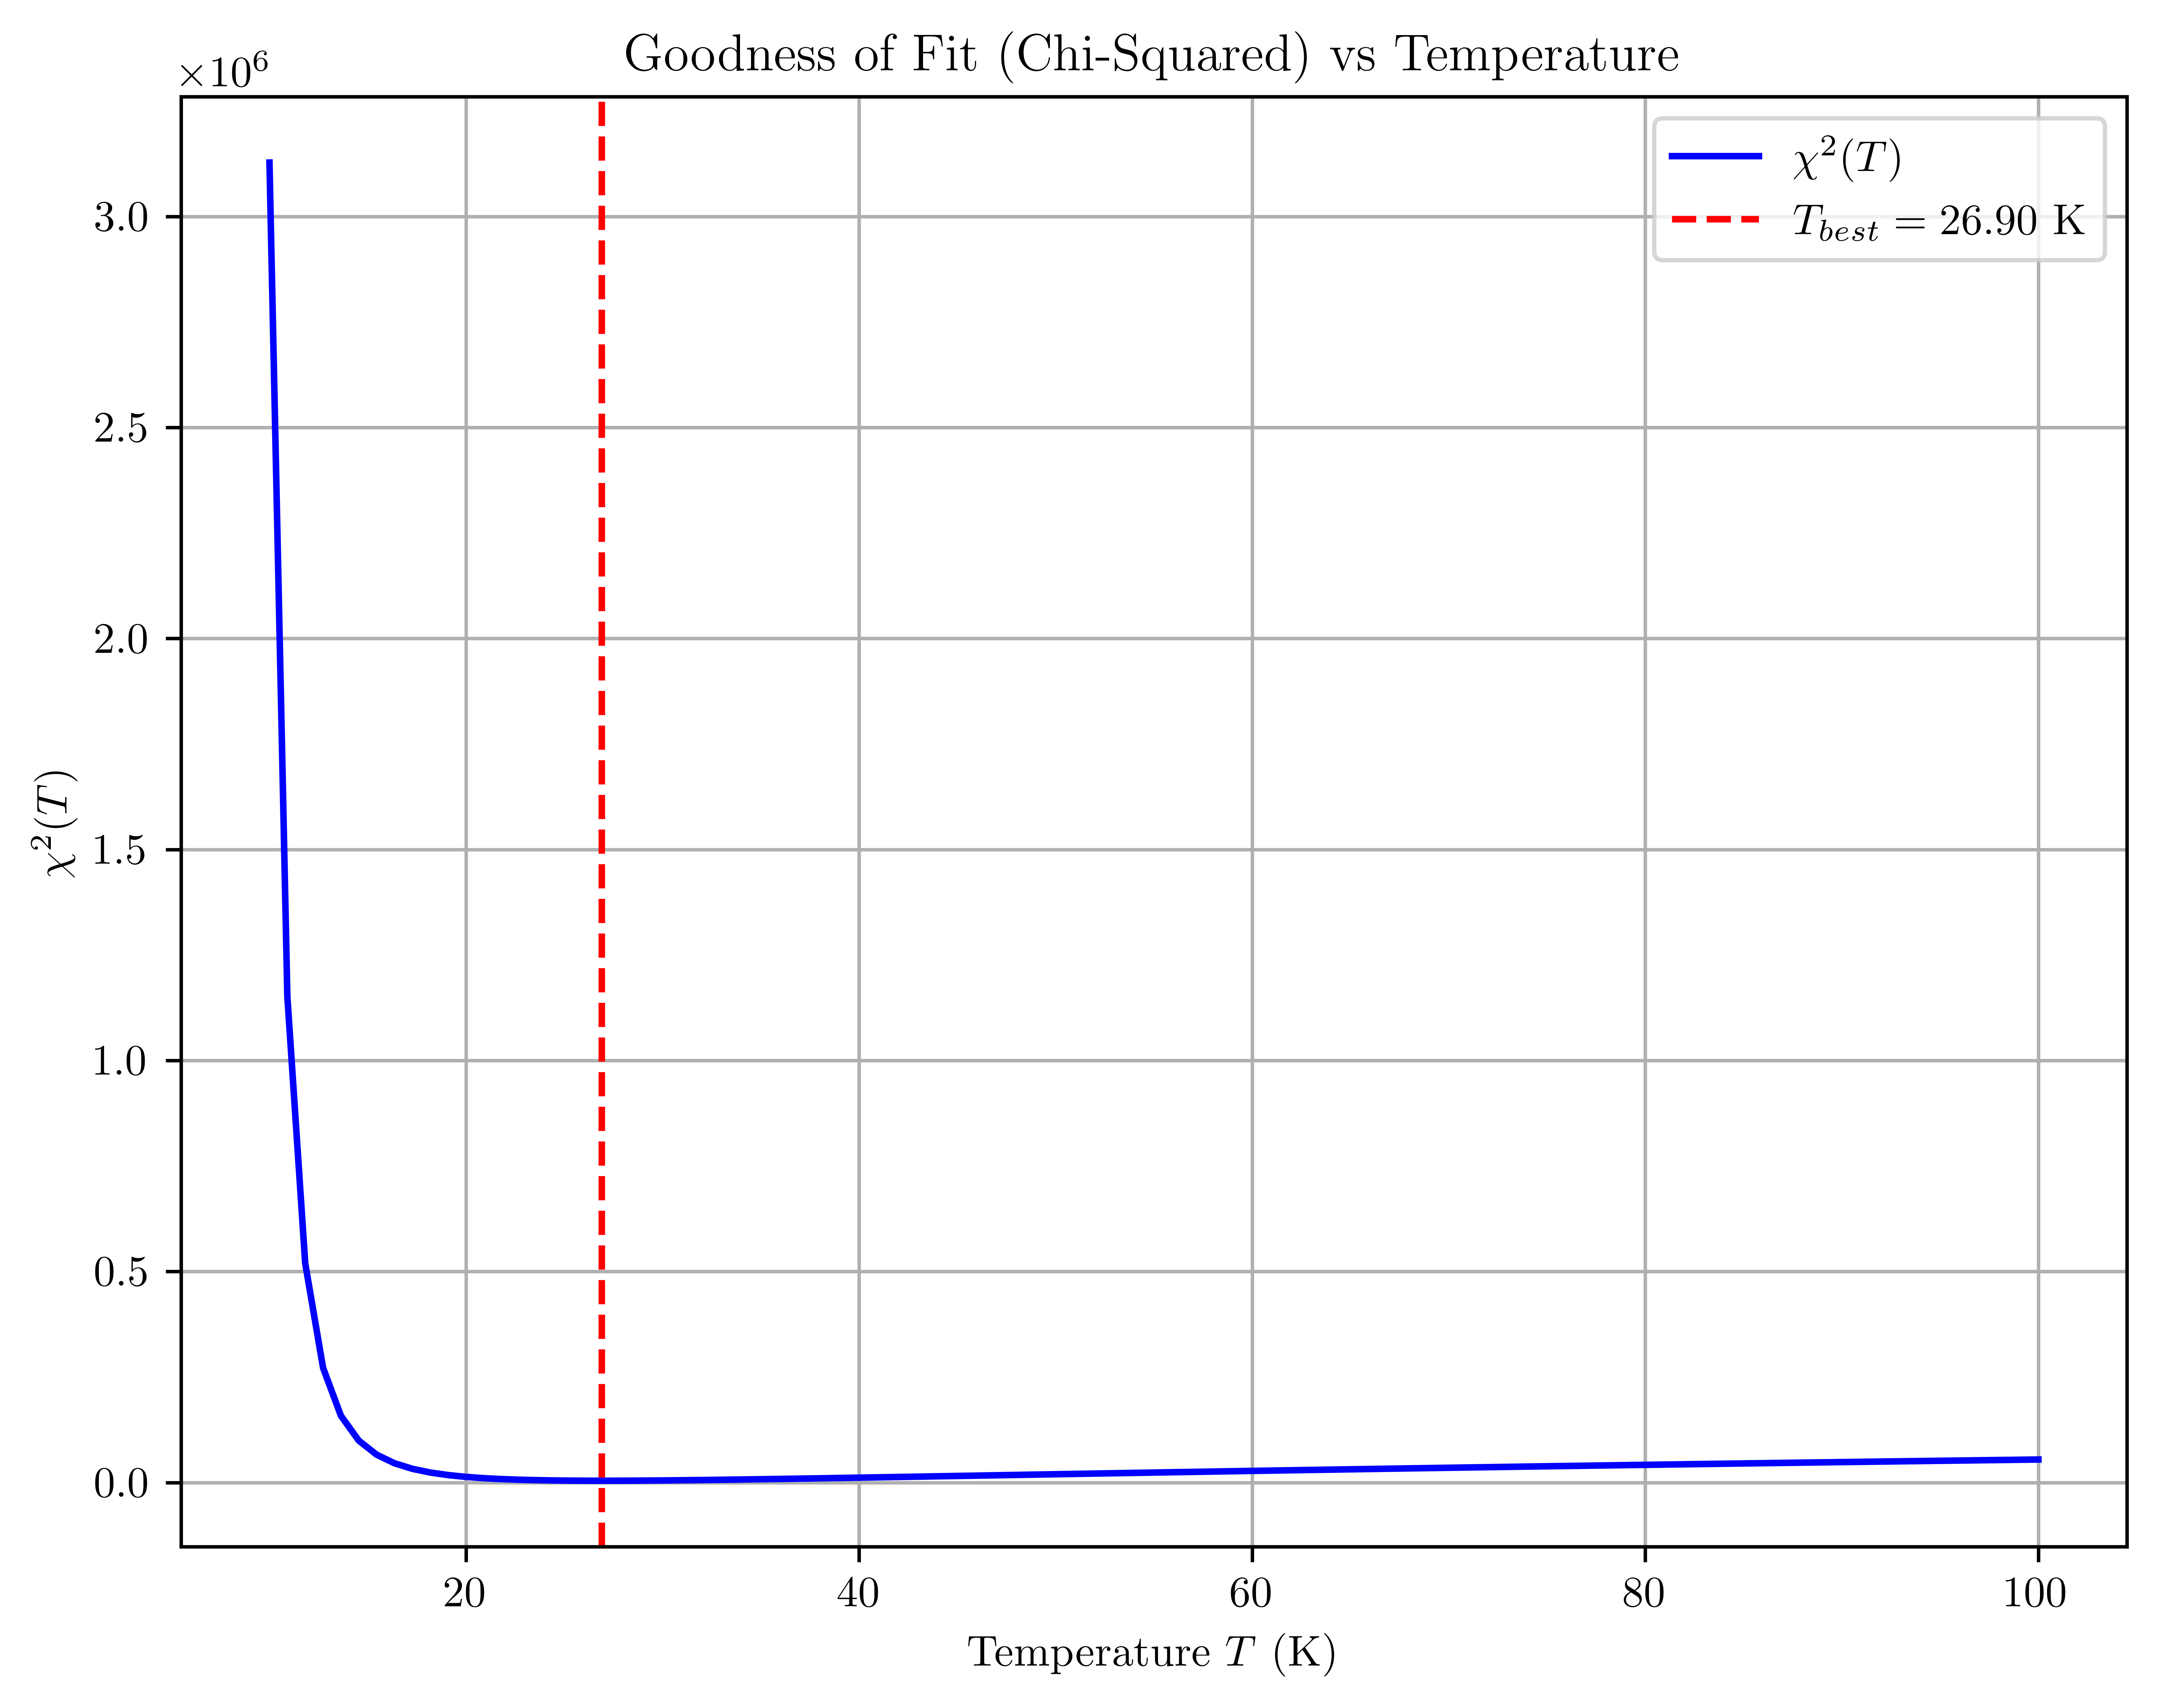

In [ ]:

def compute_chi_squared(observed, expected):
   
    return np.sum((observed - expected) ** 2 / expected)


def goodness_of_fit(T, data, bins, k_B):
    
    beta = 1 / (k_B * T)
    hist, bin_edges = np.histogram(data, bins=bins, range=(0, np.percentile(data, 99.9)), density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]
   
    expected_counts = pdf(bin_centers, beta) * bin_width * len(data)
    
   
    return compute_chi_squared(hist, expected_counts)

N = 100000  
bins = 50  
T_values = np.linspace(10, 100, 100)  


T_ref = 30  
beta_ref = 1 / (k_B * T_ref)
energy_samples = sample_energy_inverse_transform(N, beta_ref)


chi_squared_values = [goodness_of_fit(T, energy_samples, bins, k_B) for T in T_values]


result = minimize(lambda T: goodness_of_fit(T[0], energy_samples, bins, k_B), x0=[T_ref], bounds=[(10, 100)])
T_best = result.x[0]
print(f"Least Squares Estimate of T (T_best): {T_best:.5f} K")


def numerical_second_derivative(f, x, dx=1e-5):
    
    return (f(x + dx) - 2 * f(x) + f(x - dx)) / dx**2

chi_squared_func = lambda T: goodness_of_fit(T, energy_samples, bins, k_B)
second_derivative_at_T_best = numerical_second_derivative(chi_squared_func, T_best)
variance_T_best = 1 / second_derivative_at_T_best if second_derivative_at_T_best > 0 else np.inf
print(f"Variance of T_best: {variance_T_best:.5f} K^2")


plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(T_values, chi_squared_values, label=r"$\chi^2(T)$", color="blue")
plt.axvline(T_best, color="red", linestyle="--", label=f"$T_{{best}} = {T_best:.2f}$ K")
plt.xlabel(r"Temperature $T$ (K)")
plt.ylabel(r"$\chi^2(T)$")
plt.title("Goodness of Fit (Chi-Squared) vs Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
k_B = 1.380649e-23 
T_ref = 30  
beta_ref = 1 / (k_B * T_ref)
sigma = 0.05  
N = 100000  
bins = 50  

In [20]:

energy_samples = sample_energy_inverse_transform(N, beta_ref)


mean_energy = np.mean(energy_samples)


T_estimated = (2 * mean_energy) / k_B
print(f"Estimated Temperature (T): {T_estimated:.5f} K")

variance_energy = np.var(energy_samples)  


variance_T = (4 * variance_energy) / (k_B**2)
print(f"Variance of Estimated Temperature (T): {variance_T:.5e} K^2")

Estimated Temperature (T): 29.87663 K
Variance of Estimated Temperature (T): 1.78785e+03 K^2


Comparison of Results from Task 4:
            Method   T (K)  Var(T) (K^2)  Relative Deviation (%)
0       Likelihood  29.970  6.906000e-24                0.100000
1  Goodness of Fit  26.949  5.500000e-03               10.170000
2      Sample Mean  29.941  1.810000e+03                0.196667


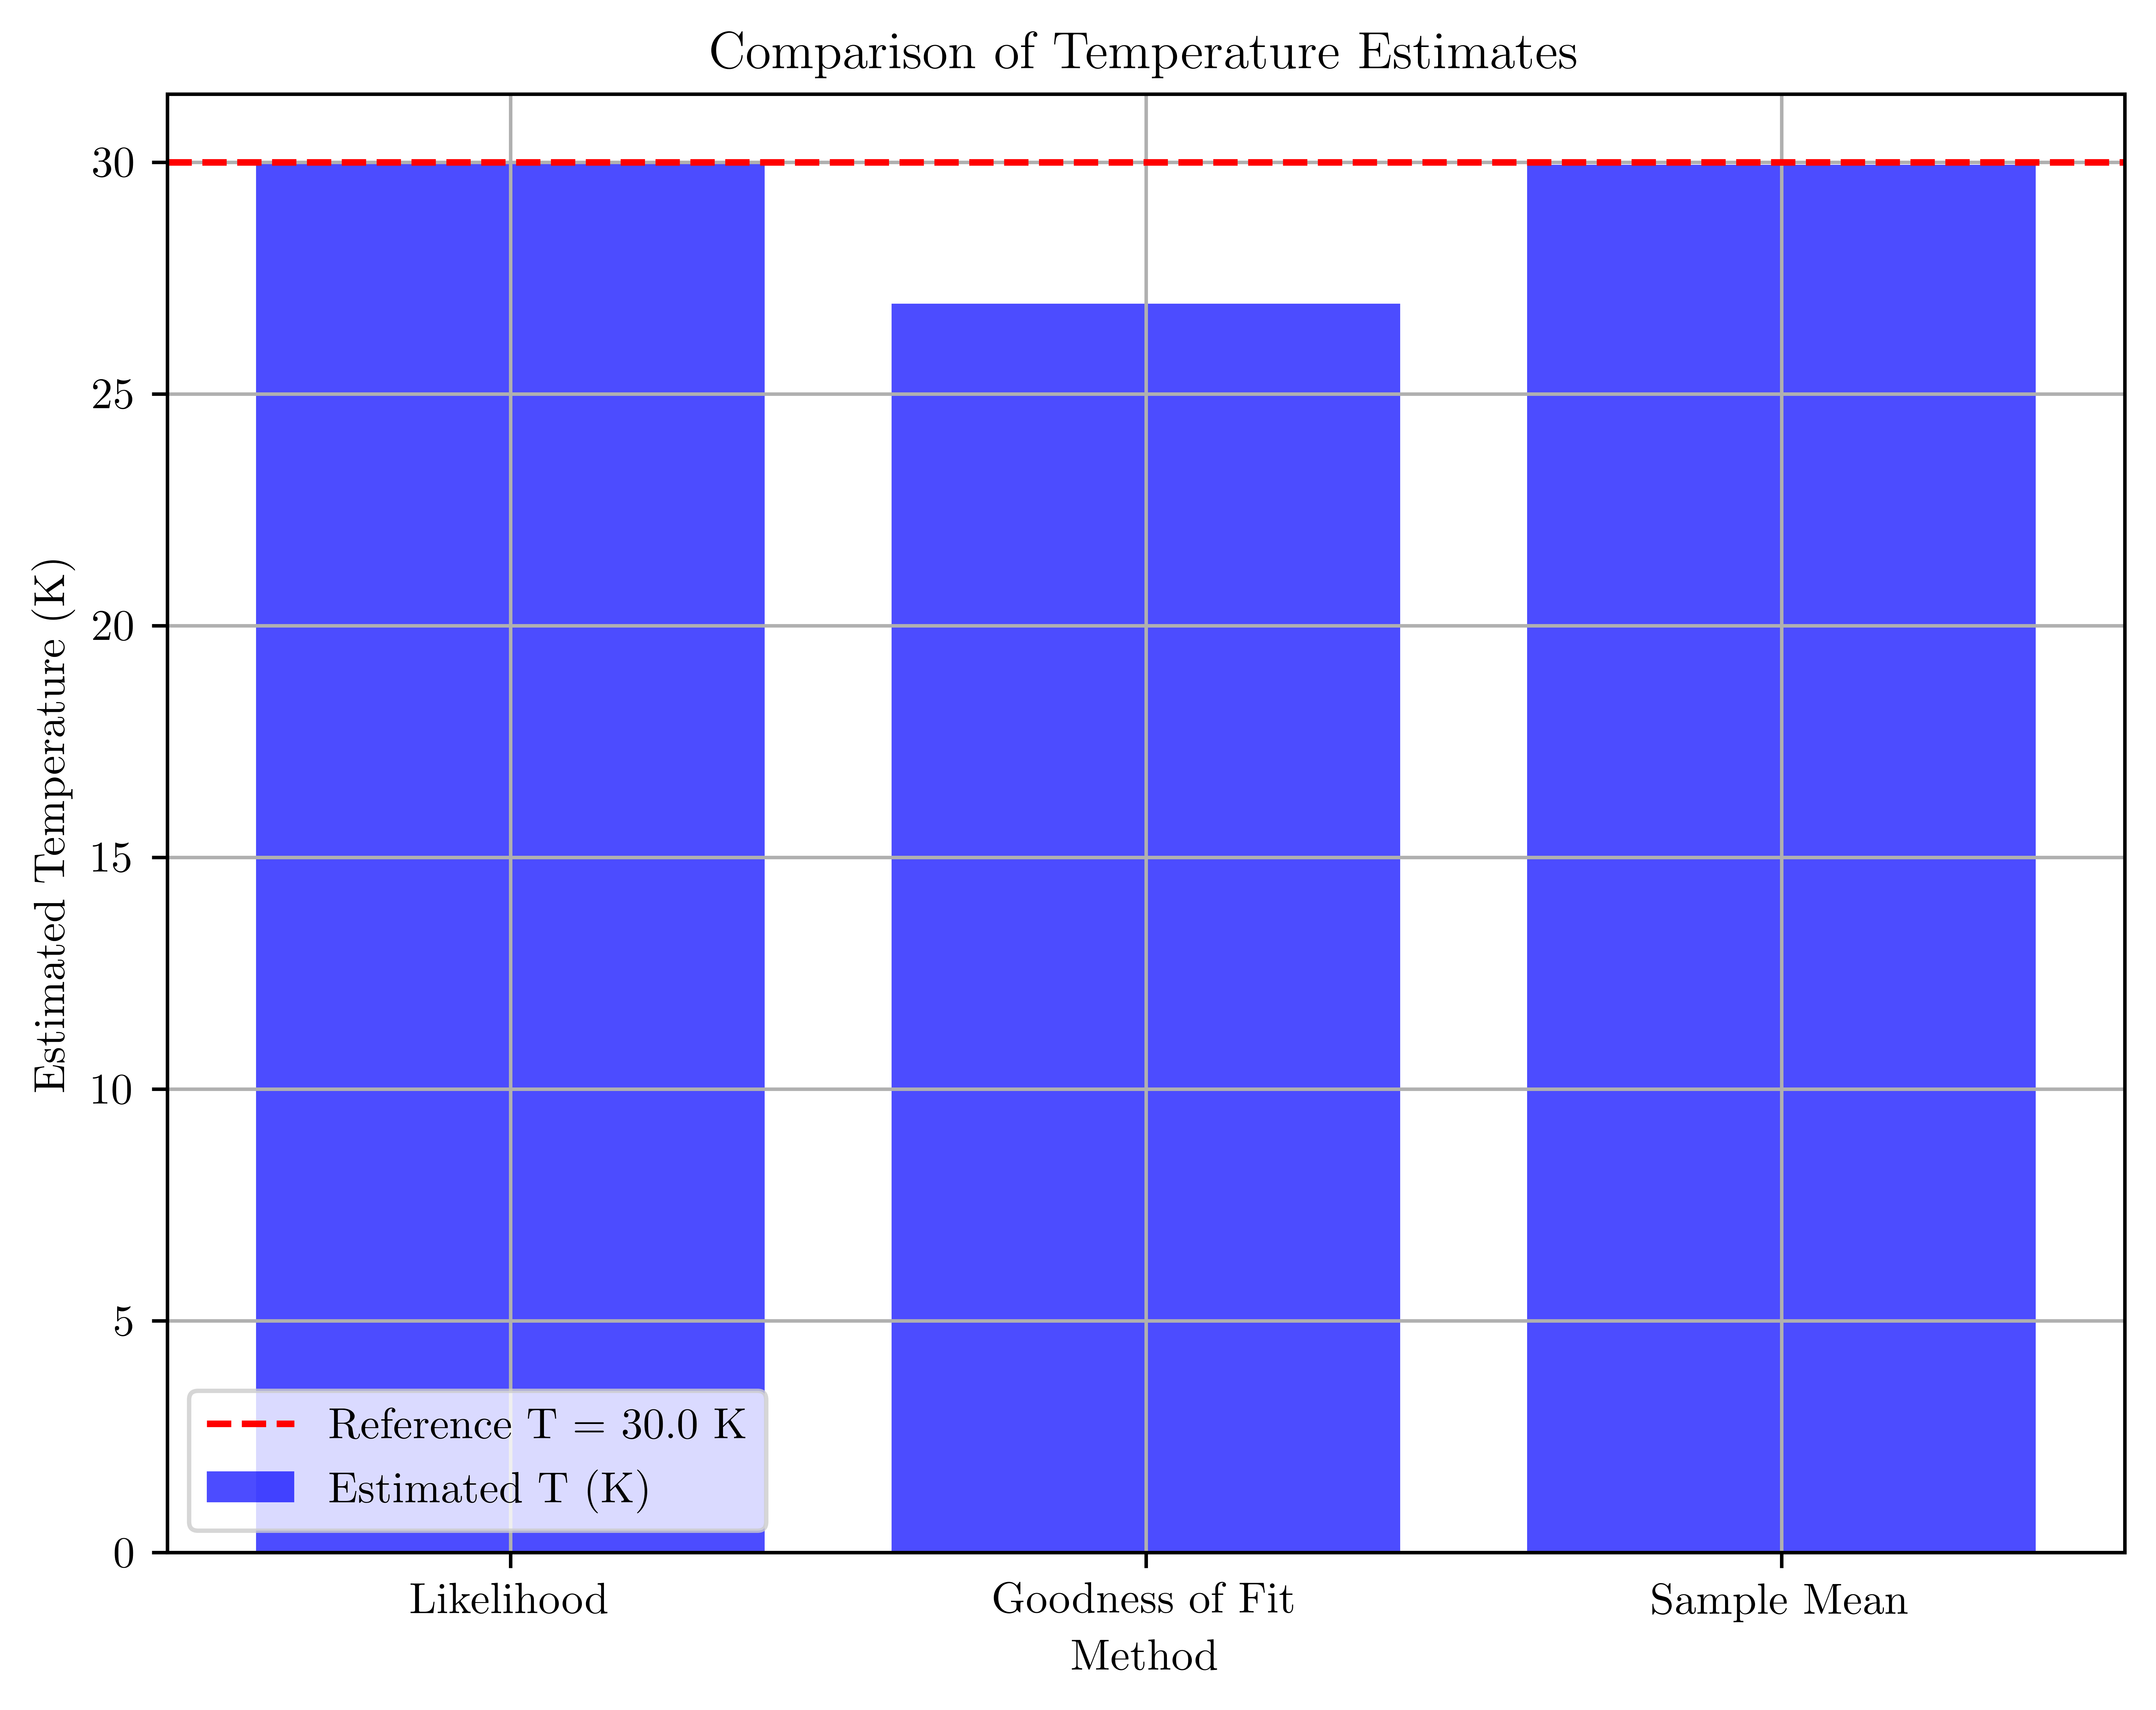

RuntimeError: latex was not able to process the following string:
b'Variance (K^2)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpvux5_yd7 d4451cd8aa8afcc8c86373ea89cc5722.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d4451cd8aa8afcc8c86373ea89cc5722.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2021/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2021/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2021/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2021/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2021/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file d4451cd8aa8afcc8c86373ea89cc5722.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.30 {\rmfamily Variance (K^
                            2)}%
No pages of output.
Transcript written on tmpvux5_yd7/d4451cd8aa8afcc8c86373ea89cc5722.log.




<Figure size 8000x6000 with 1 Axes>

In [ ]:

methods = ["Likelihood", "Goodness of Fit", "Sample Mean"]
temperatures = [29.97, 26.949, 29.941]  
variances = [6.906e-24, 5.50e-3, 1.81e3] 
T_ref = 30.0 


relative_deviations = [abs(T - T_ref) / T_ref * 100 for T in temperatures]


data = {
    "Method": methods,
    "T (K)": temperatures,
    "Var(T) (K^2)": variances,
    "Relative Deviation (%)": relative_deviations,
}
df = pd.DataFrame(data)


print("Comparison of Results from Task 4:")
print(df)


plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(methods, temperatures, alpha=0.7, label="Estimated T (K)", color="blue")
plt.axhline(y=T_ref, color="red", linestyle="--", label=f"Reference T = {T_ref} K")
plt.xlabel("Method")
plt.ylabel("Estimated Temperature (K)")
plt.title("Comparison of Temperature Estimates")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(methods, variances, alpha=0.7, label="Variance Var(T) (K^2)", color="green")
plt.yscale("log") 
plt.xlabel("Method")
plt.ylabel("Variance (K^2)")
plt.title("Comparison of Variances")
plt.legend()
plt.grid(True)
plt.show()

Total Pairs Tested: 100
Rejected Pairs (p < 0.05): 8
Accepted Pairs (p >= 0.05): 92


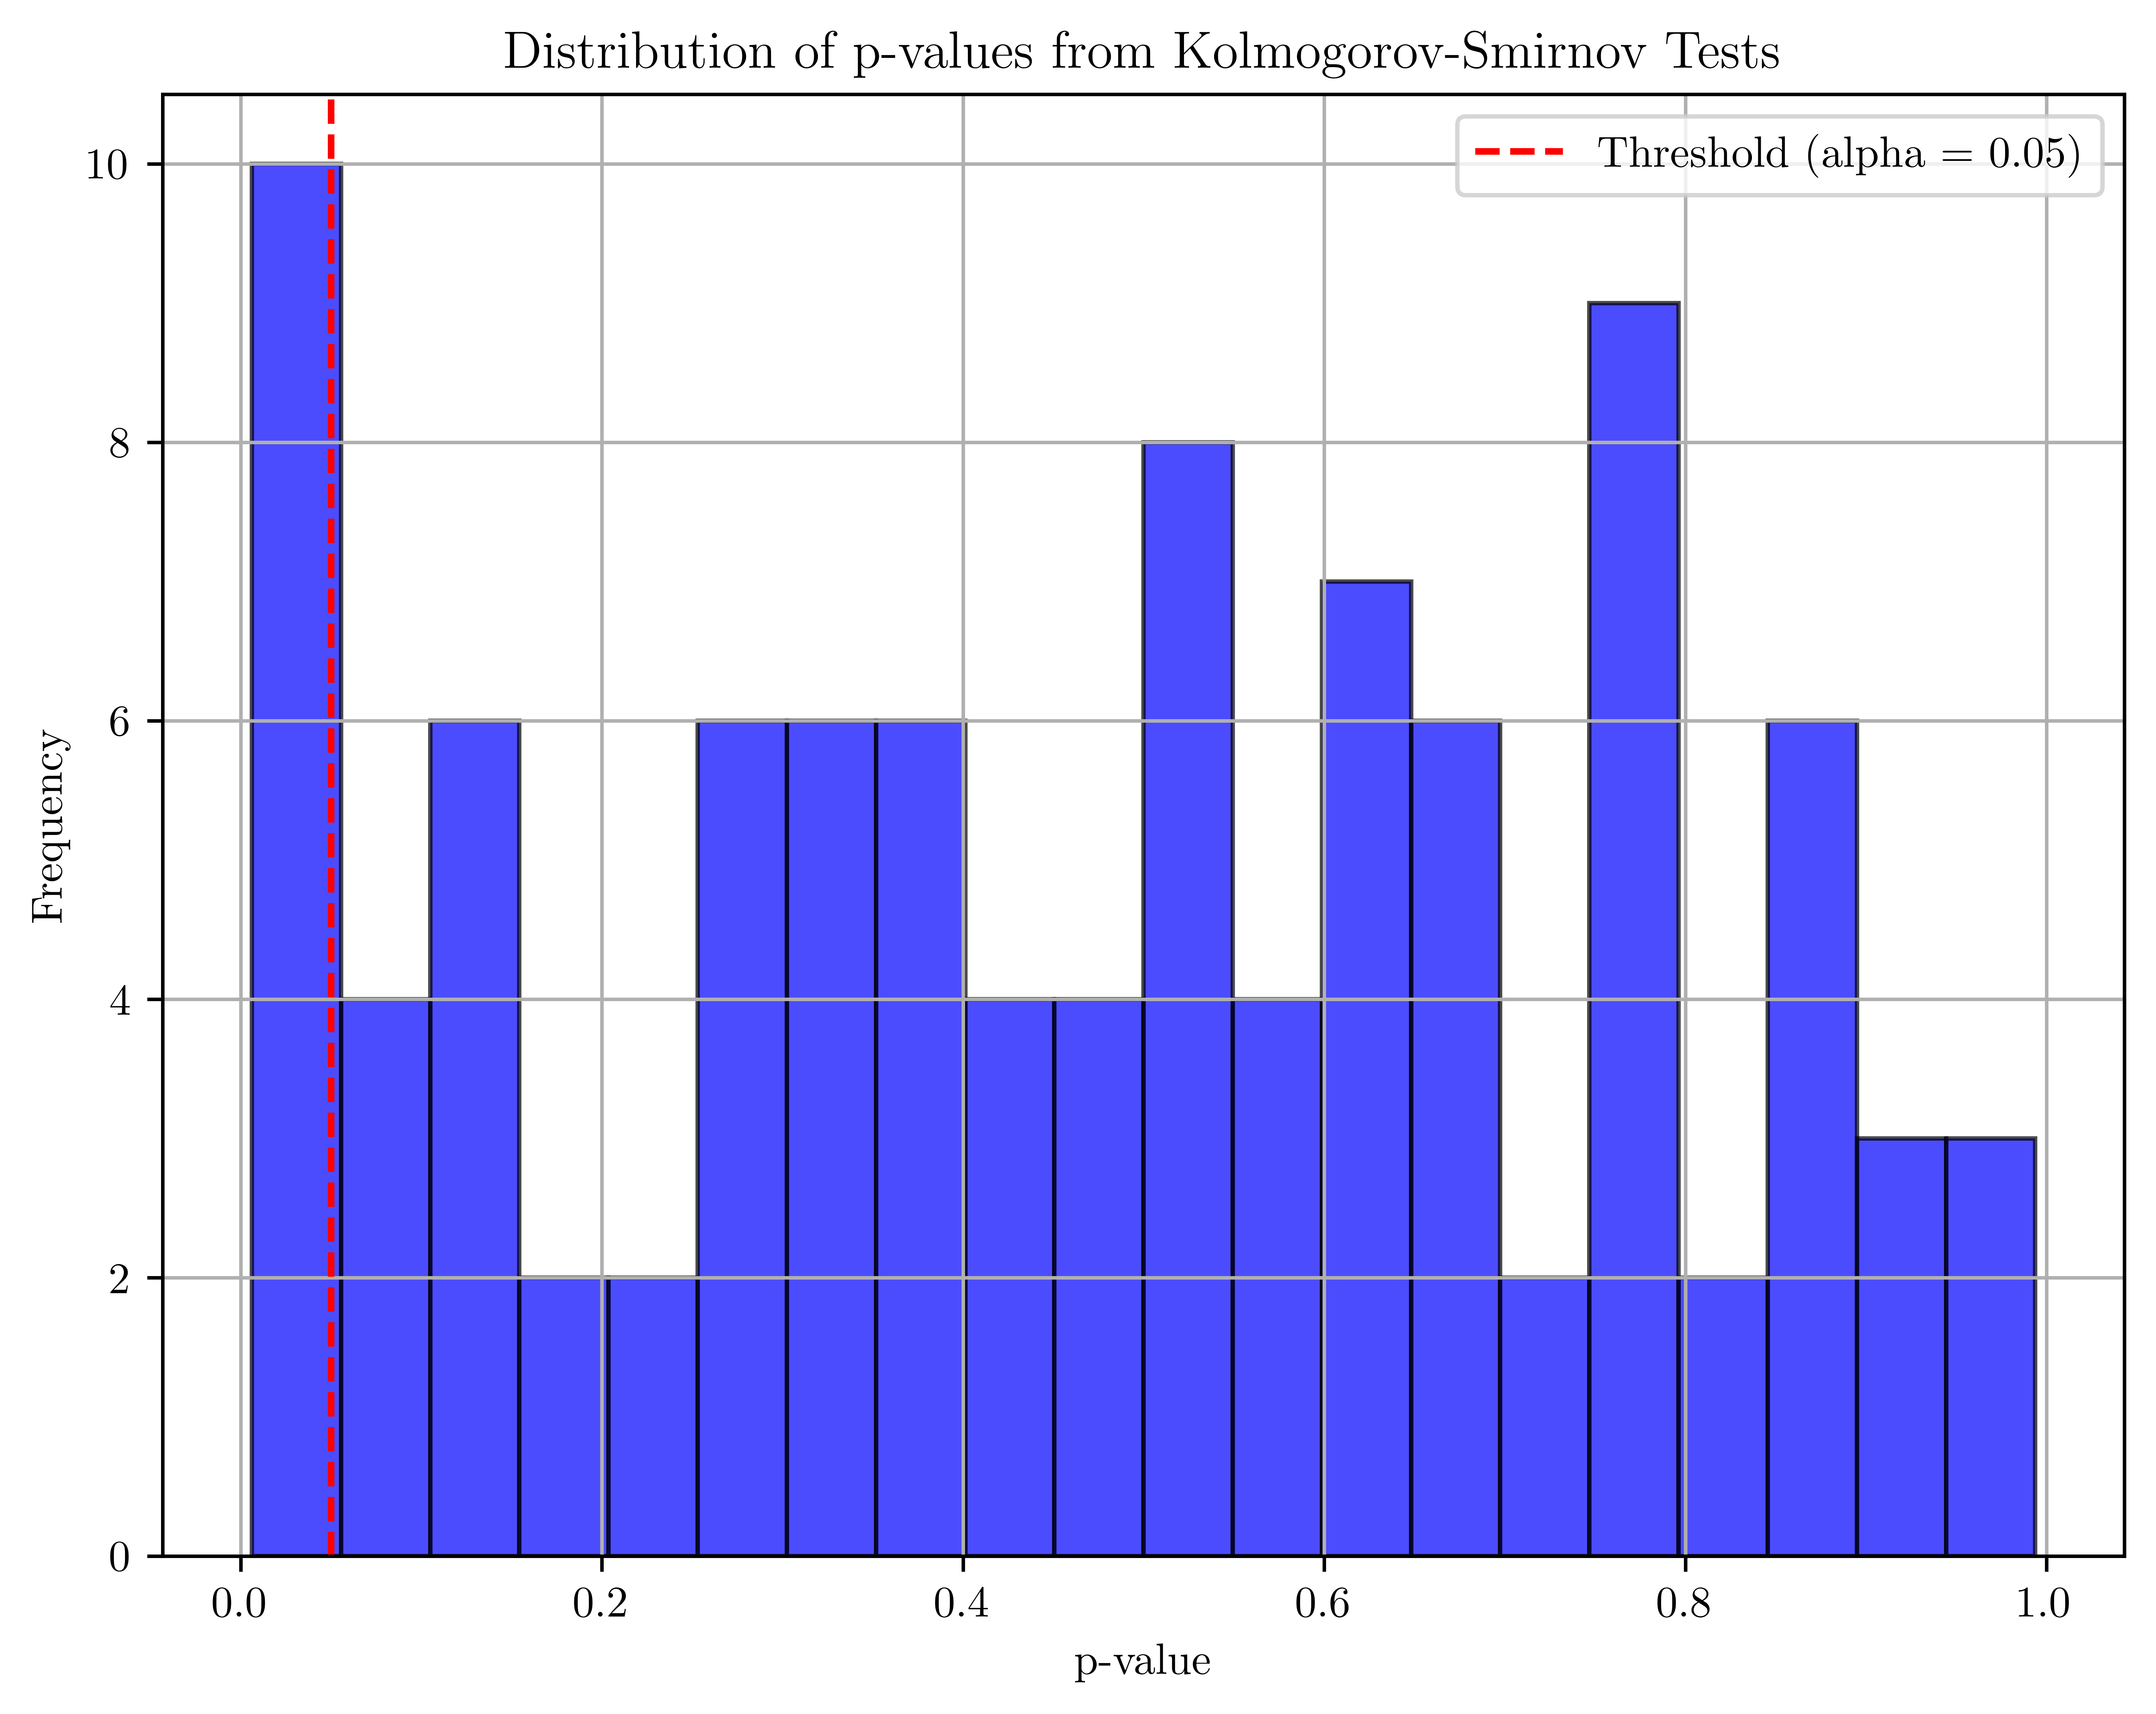

In [ ]:

N_exp = 200  
N_samples = 1000  
T = 30  
beta = 1 / (k_B * T)  
alpha = 0.05 


datasets = [sample_energy_inverse_transform(N_samples, beta) for _ in range(N_exp)]


pairs = [(datasets[2*i], datasets[2*i+1]) for i in range(N_exp // 2)]


results = []
for i, (data1, data2) in enumerate(pairs):
    ks_stat, p_value = ks_2samp(data1, data2)
    results.append((ks_stat, p_value))


rejected_pairs = sum(1 for _, p_value in results if p_value < alpha)
accepted_pairs = len(results) - rejected_pairs

print(f"Total Pairs Tested: {len(results)}")
print(f"Rejected Pairs (p < {alpha}): {rejected_pairs}")
print(f"Accepted Pairs (p >= {alpha}): {accepted_pairs}")


p_values = [p_value for _, p_value in results]
plt.figure(figsize=(8, 6), dpi=1000)
plt.hist(p_values, bins=20, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(alpha, color="red", linestyle="--", label=f"Threshold (alpha = {alpha})")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("Distribution of p-values from Kolmogorov-Smirnov Tests")
plt.legend()
plt.grid(True)
plt.show()

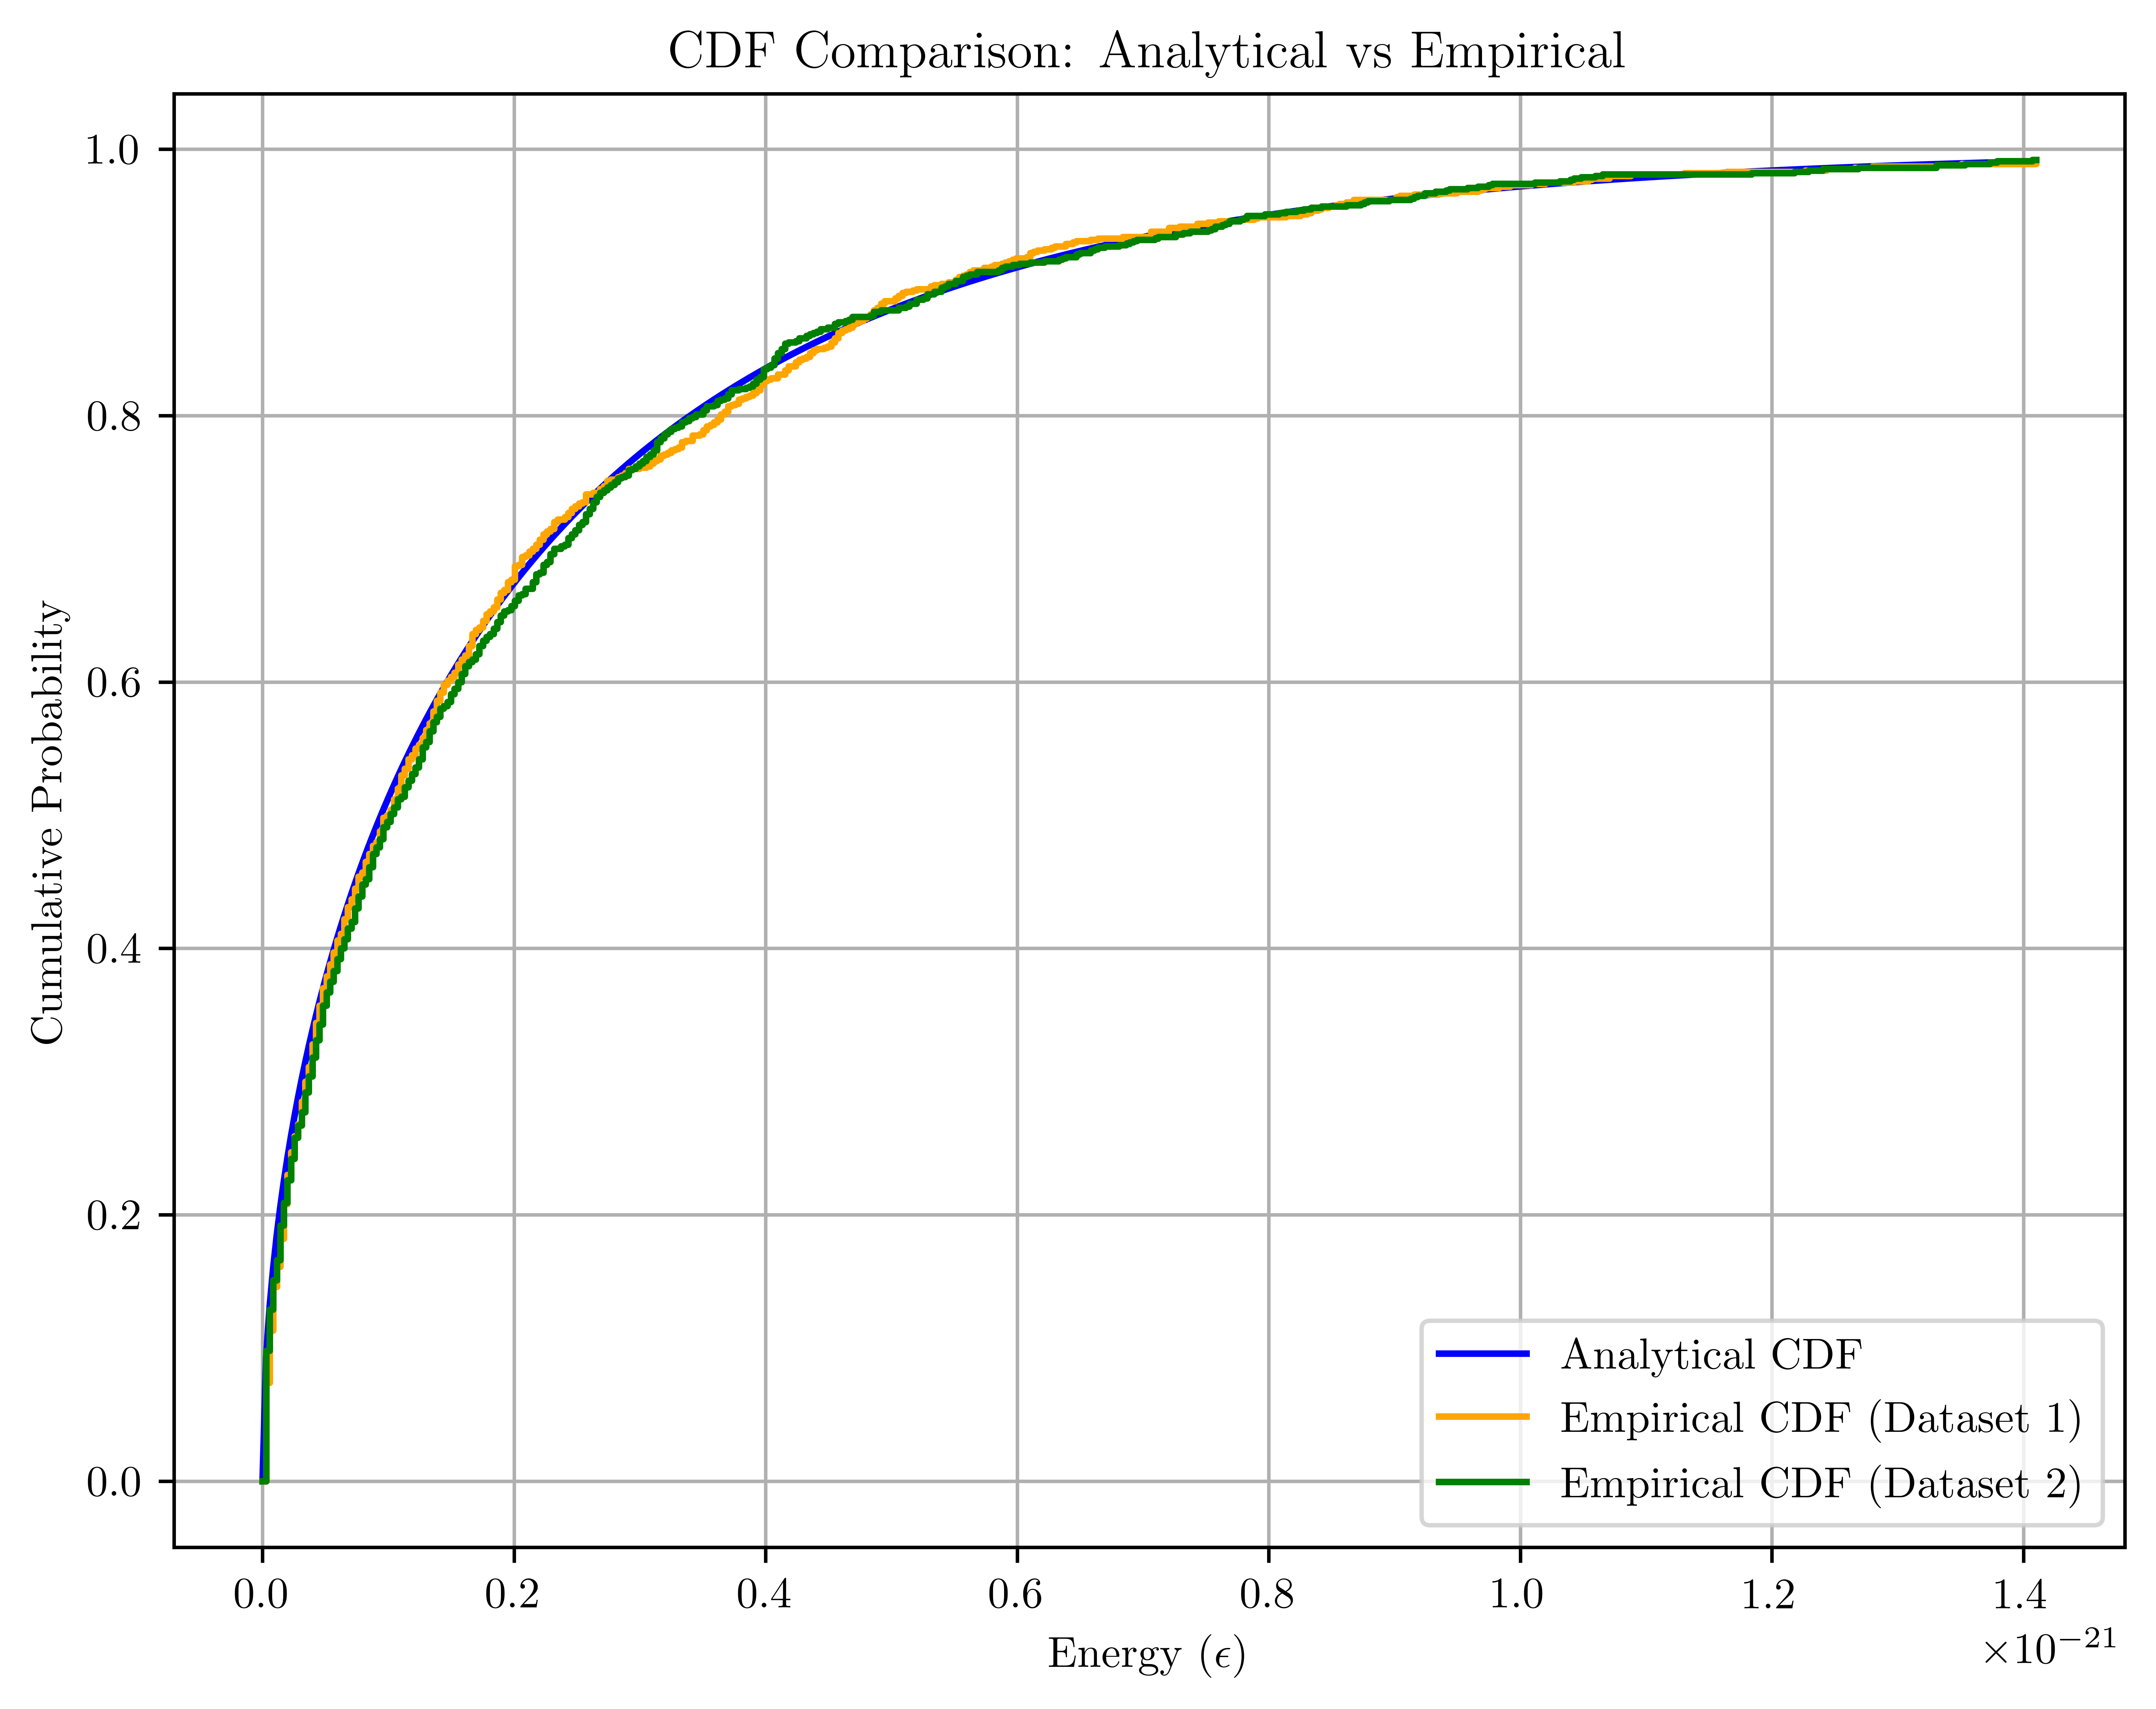

In [ ]:



def analytical_cdf(eps, beta):
   
    return erf(np.sqrt(beta * eps))


def empirical_cdf(data, x_values):
   
    cdf = np.array([np.sum(data <= x) / len(data) for x in x_values])
    return cdf

T = 30  
beta = 1 / (k_B * T)
N_samples = 1000  

data1 = sample_energy_inverse_transform(N_samples, beta)
data2 = sample_energy_inverse_transform(N_samples, beta)


x_values = np.linspace(0, np.percentile(data1, 99), 500)


empirical_cdf1 = empirical_cdf(data1, x_values)
empirical_cdf2 = empirical_cdf(data2, x_values)
analytical_cdf_values = analytical_cdf(x_values, beta)


plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(x_values, analytical_cdf_values, label="Analytical CDF", color="blue")
plt.step(x_values, empirical_cdf1, label="Empirical CDF (Dataset 1)", color="orange", where="post")
plt.step(x_values, empirical_cdf2, label="Empirical CDF (Dataset 2)", color="green", where="post")
plt.xlabel("Energy ($\epsilon$)")
plt.ylabel("Cumulative Probability")
plt.title("CDF Comparison: Analytical vs Empirical")
plt.legend()
plt.grid(True)
plt.show()

/Users/gabriel/Code/Stats Project/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:186: RuntimeWarning: floating point number truncated to an integer
  return scu._smirnovci(n, q)


Total Pairs Tested: 100
Rejected Pairs (KS statistic > Critical Distance): 100
Accepted Pairs (KS statistic <= Critical Distance): 0


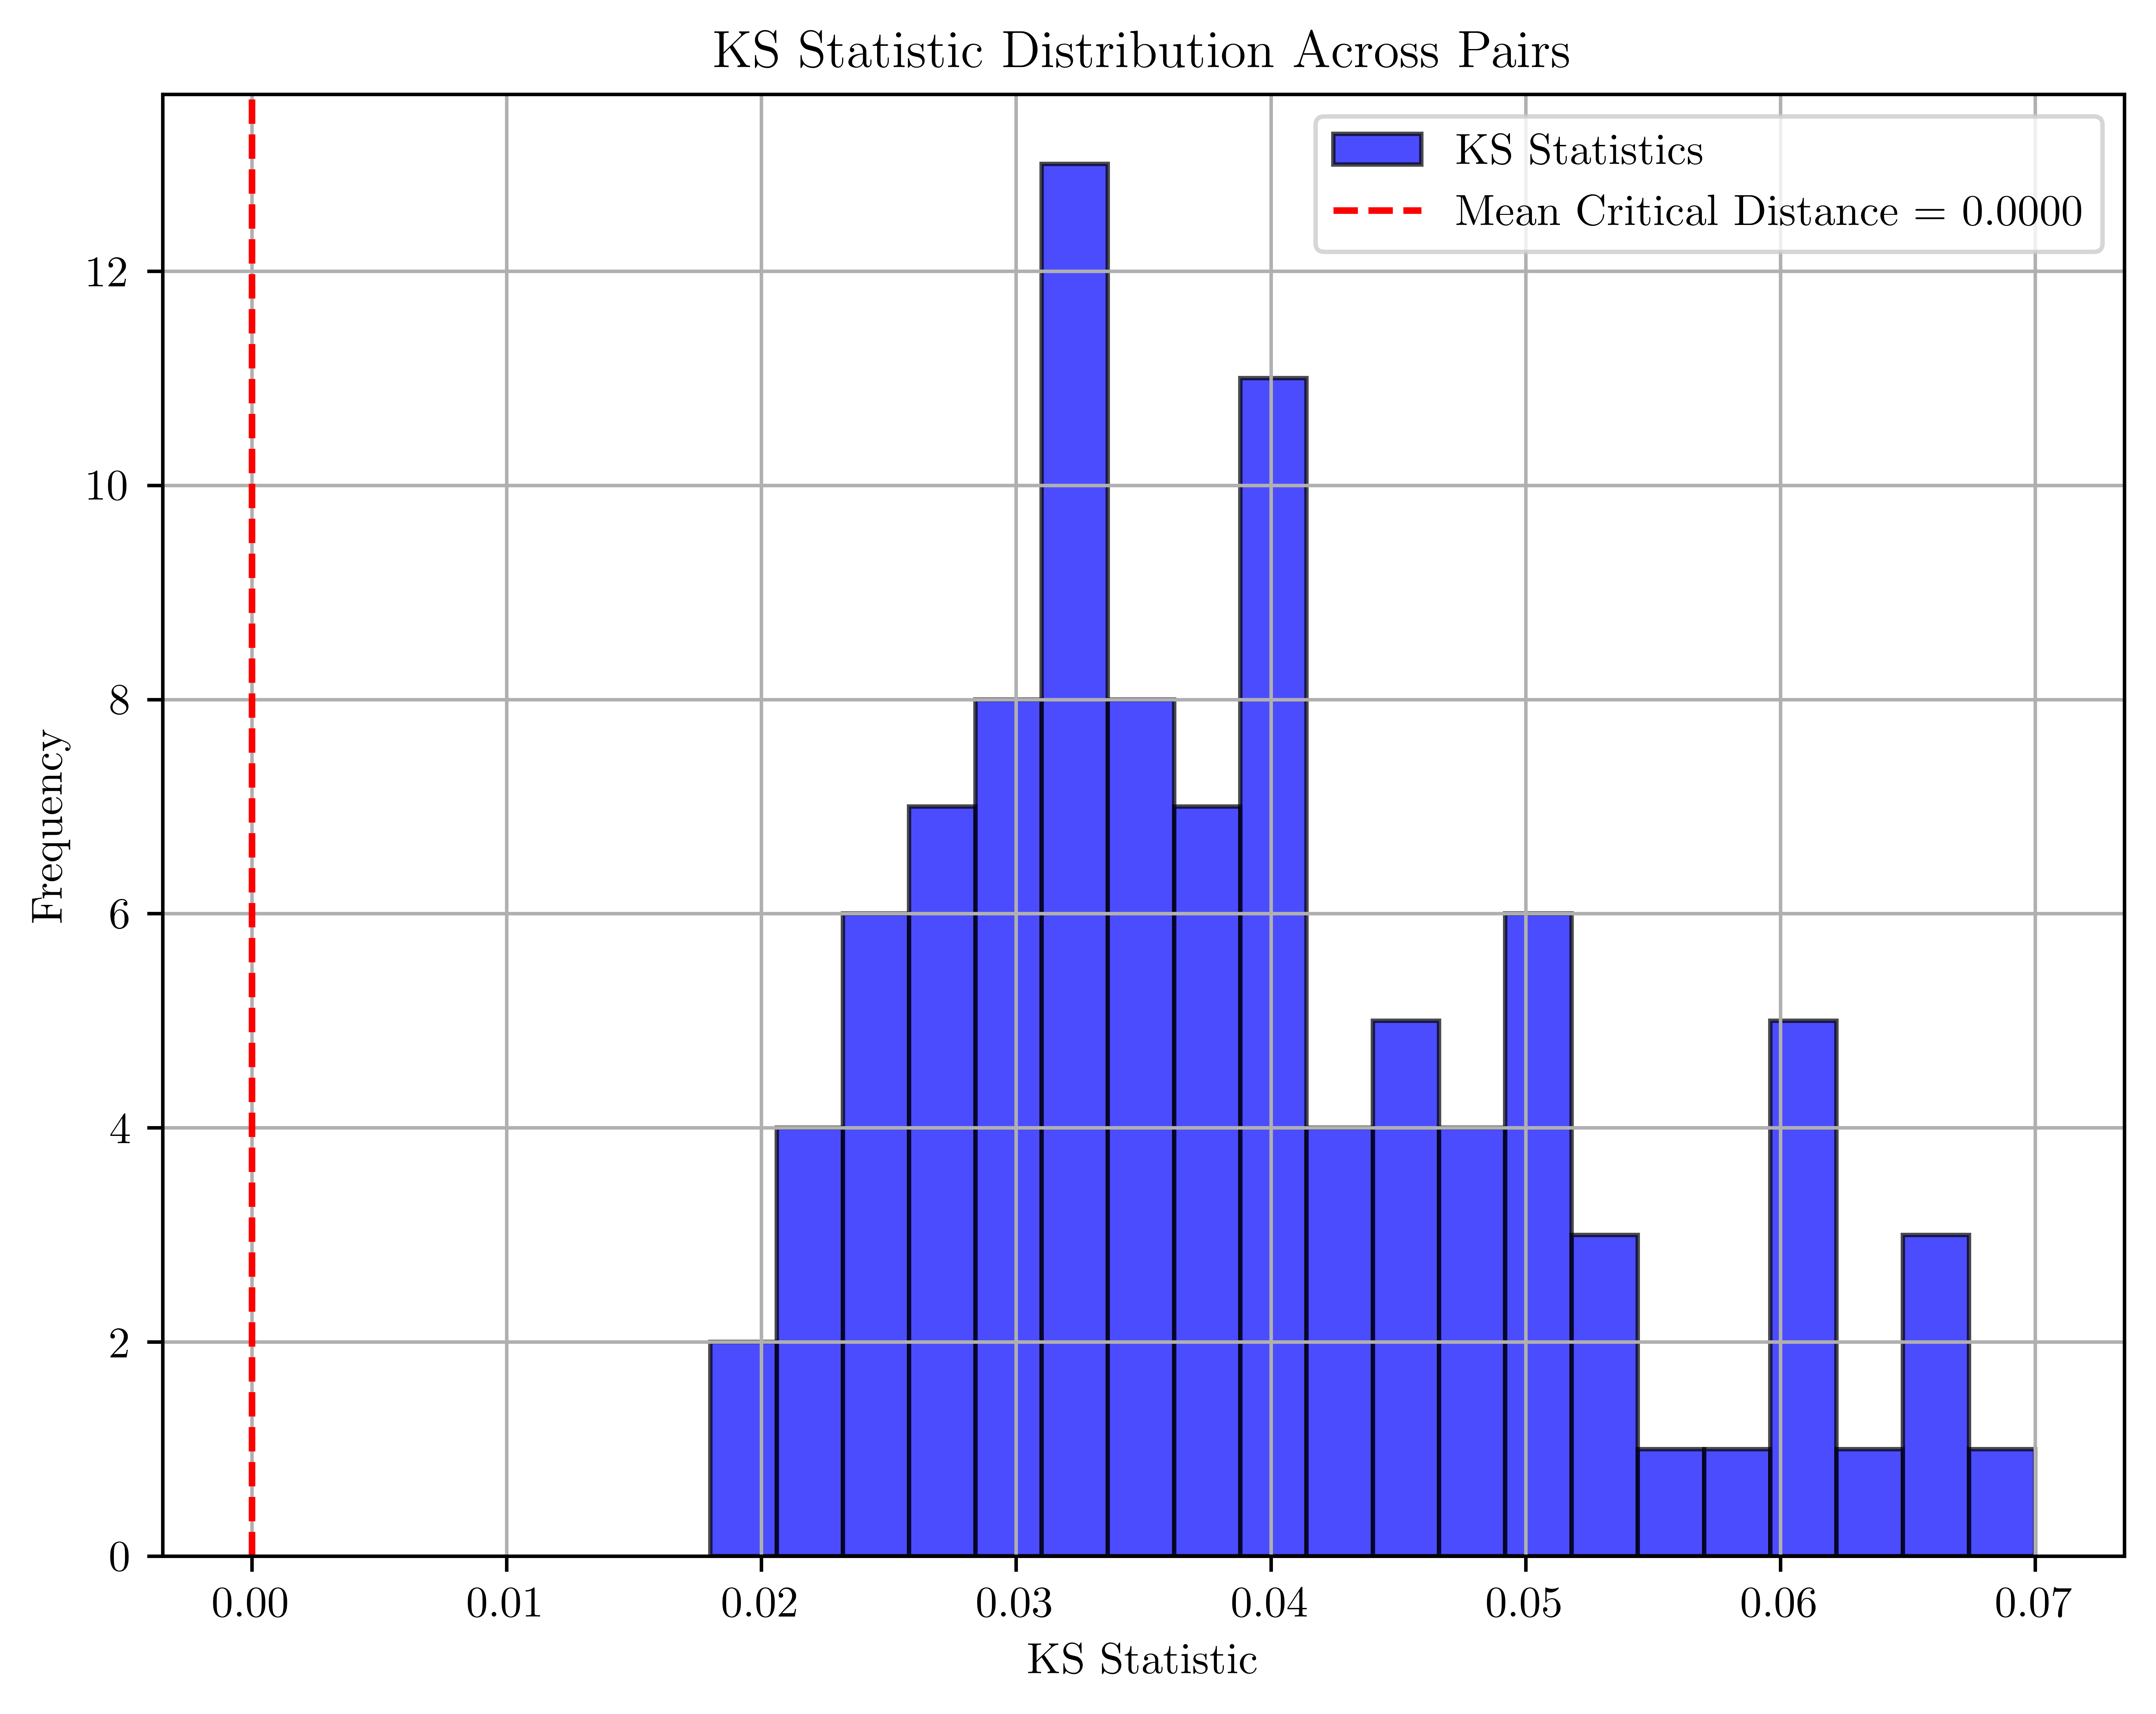

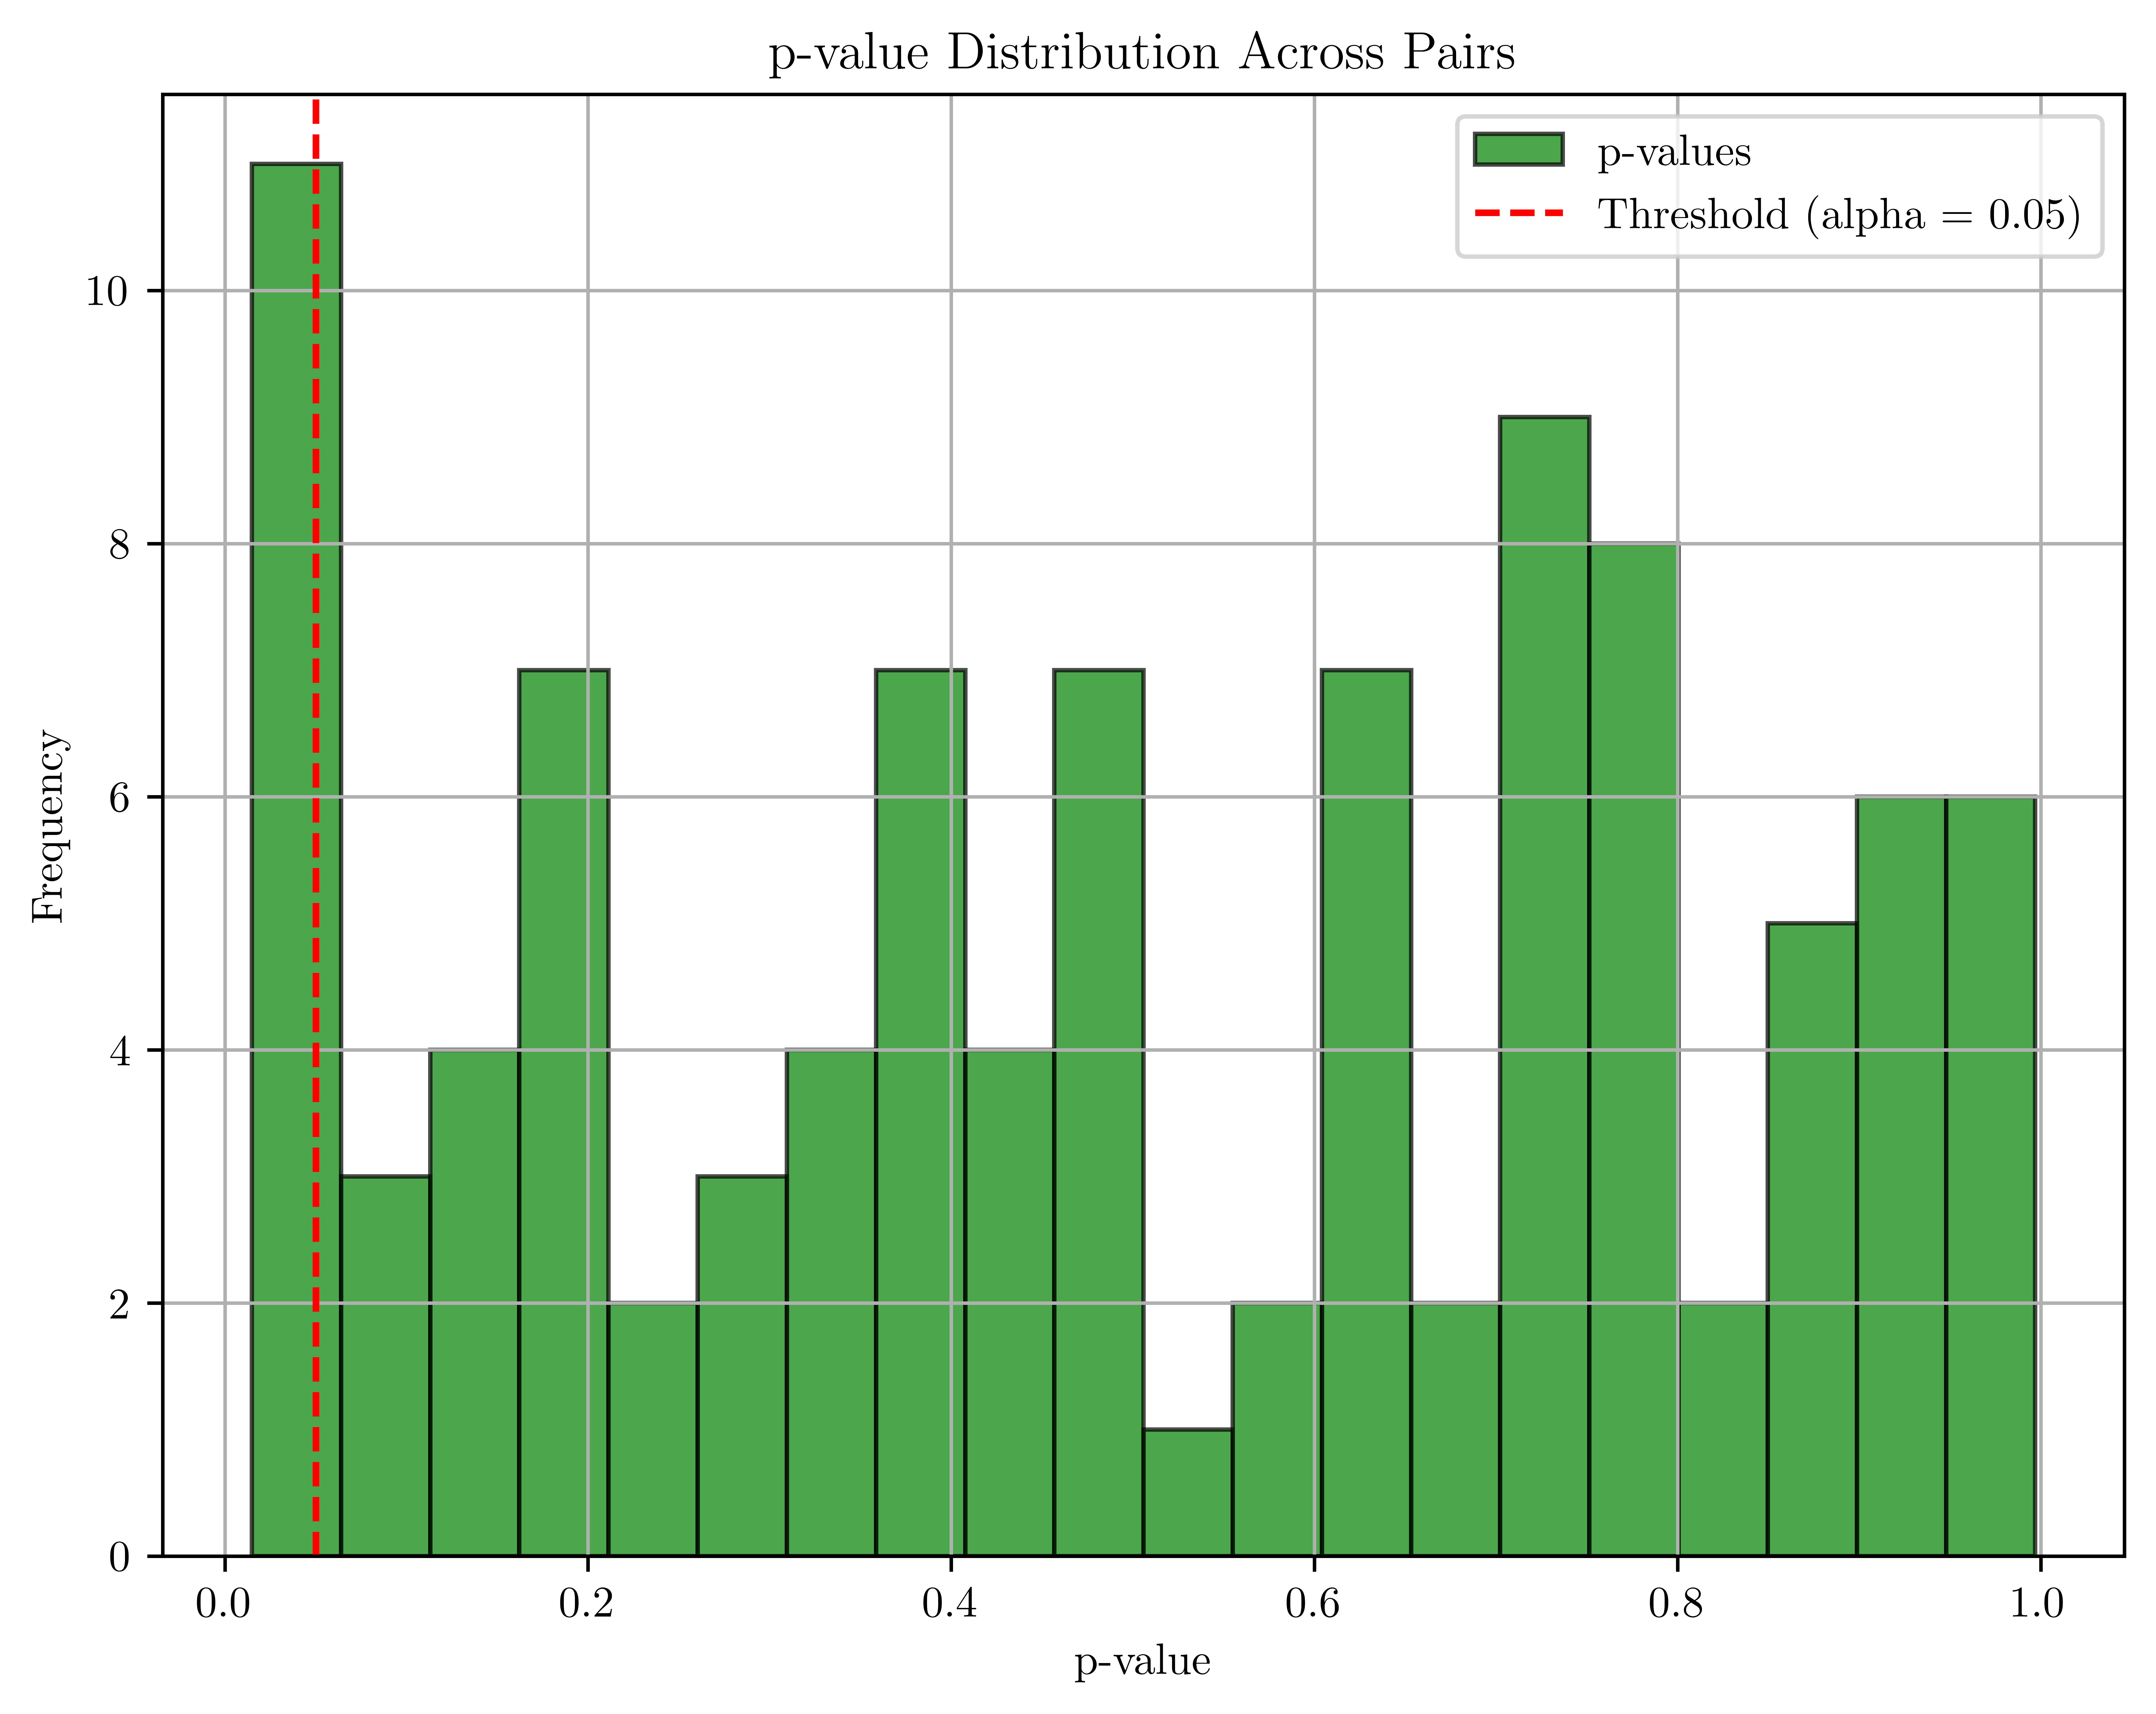

In [ ]:

N_exp = 200  
N_samples = 1000  
T = 30  
beta = 1 / (k_B * T)  
alpha = 0.05 

def calculate_c_alpha(alpha):
   
    return ksone.ppf(1 - alpha / 2, float('inf'))  


datasets = [sample_energy_inverse_transform(N_samples, beta) for _ in range(N_exp)]


pairs = [(datasets[2 * i], datasets[2 * i + 1]) for i in range(N_exp // 2)]


results = []
critical_distance = []
c_alpha = calculate_c_alpha(alpha)  

for i, (data1, data2) in enumerate(pairs):
    
    ks_stat, p_value = ks_2samp(data1, data2)
    results.append((ks_stat, p_value))

    
    D_crit = c_alpha * np.sqrt((N_samples + N_samples) / (N_samples * N_samples))
    critical_distance.append(D_crit)


rejected_pairs = []
accepted_pairs = []

for i, (ks_stat, p_value) in enumerate(results):
    if ks_stat > critical_distance[i]:
        rejected_pairs.append(i)
    else:
        accepted_pairs.append(i)


print(f"Total Pairs Tested: {len(pairs)}")
print(f"Rejected Pairs (KS statistic > Critical Distance): {len(rejected_pairs)}")
print(f"Accepted Pairs (KS statistic <= Critical Distance): {len(accepted_pairs)}")


ks_stats = [r[0] for r in results]
p_values = [r[1] for r in results]

import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6), dpi=1000)
plt.hist(ks_stats, bins=20, alpha=0.7, color="blue", edgecolor="black", label="KS Statistics")
plt.axvline(np.mean(critical_distance), color="red", linestyle="--", label=f"Mean Critical Distance = {np.mean(critical_distance):.4f}")
plt.xlabel("KS Statistic")
plt.ylabel("Frequency")
plt.title("KS Statistic Distribution Across Pairs")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6), dpi=1000)
plt.hist(p_values, bins=20, alpha=0.7, color="green", edgecolor="black", label="p-values")
plt.axvline(alpha, color="red", linestyle="--", label=f"Threshold (alpha = {alpha})")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("p-value Distribution Across Pairs")
plt.legend()
plt.grid(True)
plt.show()

# Task 6

In [85]:
T_ref=30
beta = 1/(kb*T_ref)
k_B = 1.3806e-23 
N = 100000 
log_likelihoods = []
sigma = 0.05



def apply_gaussian_smearing(data, sigma):
    
    energies_noisy = data + np.random.normal(0, sigma, N)
    
    return energies_noisy


energy = sample_energy_inverse_transform(N, beta)
energy_noisy = energy + np.random.normal(0, sigma, N)

def log_likelihood(T, energies):
    """Log-vraisemblance pour une température donnée T."""
    beta = 1 / (kb * T)
    A = np.sqrt(beta / np.pi)
    log_likelihood_values = np.log(A) - beta * energies - 0.5 * np.log(energies)
    return -np.sum(log_likelihood_values)

results_mle_noisy = minimize(log_likelihood, 25, args=(energy_noisy,), bounds=[(1e-5, None)])
T_mle_noisy = results_mle_noisy.x[0]

def least_squares(T, hist, bin_centers):
    """Somme des carrés des écarts pour une température T."""
    beta = 1 / (kb * T)
    f_values = np.sqrt(beta / np.pi) * np.exp(-beta * bin_centers) / np.sqrt(bin_centers)
    return np.sum((hist - f_values)**2)

bins = 200
hist, bin_edges = np.histogram(energy_noisy, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

result_ls_noisy = minimize(least_squares, 25, args=(hist, bin_centers), bounds=[(1e-5, None)])
T_ls_noisy = result_ls_noisy.x[0]

mean_energy_noisy = np.mean(energy_noisy)
T_empirical_noisy = 2 * mean_energy_noisy / kb


print(T_mle_noisy)
print(T_ls_noisy)
print(T_empirical_noisy)

25.0
25.0
-2.0967602684758705e+18


/var/folders/0y/496_zl5905jfg059dd524bvm0000gn/T/ipykernel_26917/962989620.py:24: RuntimeWarning: invalid value encountered in log
  log_likelihood_values = np.log(A) - beta * energies - 0.5 * np.log(energies)
/var/folders/0y/496_zl5905jfg059dd524bvm0000gn/T/ipykernel_26917/962989620.py:33: RuntimeWarning: overflow encountered in exp
  f_values = np.sqrt(beta / np.pi) * np.exp(-beta * bin_centers) / np.sqrt(bin_centers)
/var/folders/0y/496_zl5905jfg059dd524bvm0000gn/T/ipykernel_26917/962989620.py:33: RuntimeWarning: invalid value encountered in sqrt
  f_values = np.sqrt(beta / np.pi) * np.exp(-beta * bin_centers) / np.sqrt(bin_centers)
